# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
# Imports of all used packages and libraries
import sys
import os
import git
import glob
from collections import defaultdict

In [2]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [3]:
git_root

'/blue/npadillacoreano/ryoi360/projects/reward_comp/repos/reward_competition_extention'

In [4]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os
import collections
import itertools
from collections import defaultdict
from itertools import combinations

In [7]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu


In [8]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import colorsys

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [11]:
import utilities.helper
import trodes.read_exported

In [12]:
FONTSIZE = 20

In [13]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

## Inputs & Data

Explanation of each input and where it comes from.

In [14]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [15]:
LFP_SPECTRAL_DF = pd.read_pickle("../2024_01_30_rce2_spectral_preprocessing/proc/rce_pilot_2_10_per_trial_spectral_bans_sleap.pkl")

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions 

In [16]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [17]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names




In [18]:
LFP_SPECTRAL_DF.columns

Index(['tracked_subject', 'box_number', 'sleap_name', 'video_name',
       'current_subject', 'tone_start_frame', 'reward_start_frame',
       'tone_stop_frame', 'condition', 'competition_closeness',
       ...
       'baseline_subject_thorax_to_reward_port',
       'baseline_subject_thorax_velocity', 'baseline_video_timestamps',
       'trial_agent_locations', 'trial_agent_thorax_to_reward_port',
       'trial_agent_thorax_velocity', 'trial_subject_locations',
       'trial_subject_thorax_to_reward_port', 'trial_subject_thorax_velocity',
       'trial_video_timestamps'],
      dtype='object', length=275)

## Power plots

In [19]:
LFP_SPECTRAL_DF["trial_label"]

0        win
1       lose
2       lose
3       lose
4       lose
        ... 
1364    lose
1365    lose
1366    lose
1367    lose
1368    lose
Name: trial_label, Length: 1369, dtype: object

In [20]:
LFP_SPECTRAL_DF["experiment"]

0       standard
1       standard
2       standard
3       standard
4       standard
          ...   
1364       novel
1365       novel
1366       novel
1367       novel
1368       novel
Name: experiment, Length: 1369, dtype: object

In [21]:
LFP_SPECTRAL_DF["experiment_and_label"] = LFP_SPECTRAL_DF.apply(lambda x: "{}_{}".format(x["experiment"], x["trial_label"]) if x["experiment"] != x["trial_label"] else x["experiment"], axis=1)

In [22]:
LFP_SPECTRAL_DF["experiment_and_label"].unique()

array(['standard_win', 'standard_lose', 'standard_rewarded',
       'omission_rewarded', 'omission', 'both_rewarded', 'novel_lose',
       'novel_win'], dtype=object)

In [23]:
power_columns = [col for col in LFP_SPECTRAL_DF.columns if "power" in col and "frequencies" not in col and "timestamps" not in col]

In [24]:
power_columns

['baseline_mPFC_power_theta',
 'baseline_mPFC_power_gamma',
 'baseline_MD_power_theta',
 'baseline_MD_power_gamma',
 'baseline_LH_power_theta',
 'baseline_LH_power_gamma',
 'baseline_BLA_power_theta',
 'baseline_BLA_power_gamma',
 'baseline_vHPC_power_theta',
 'baseline_vHPC_power_gamma',
 'trial_mPFC_power_theta',
 'trial_mPFC_power_gamma',
 'trial_MD_power_theta',
 'trial_MD_power_gamma',
 'trial_LH_power_theta',
 'trial_LH_power_gamma',
 'trial_BLA_power_theta',
 'trial_BLA_power_gamma',
 'trial_vHPC_power_theta',
 'trial_vHPC_power_gamma']

In [25]:
# LFP_SPECTRAL_DF = 
LFP_SPECTRAL_DF = LFP_SPECTRAL_DF[LFP_SPECTRAL_DF["experiment"] != "omission"]

In [64]:
LFP_SPECTRAL_DF[LFP_SPECTRAL_DF["baseline_subject_thorax_velocity"].apply(lambda x: np.nanmean(x)).isna()]

,tracked_subject,box_number,sleap_name,video_name,current_subject,tone_start_frame,reward_start_frame,tone_stop_frame,condition,competition_closeness,...,baseline_subject_thorax_velocity,baseline_video_timestamps,trial_agent_locations,trial_agent_thorax_to_reward_port,trial_agent_thorax_velocity,trial_subject_locations,trial_subject_thorax_to_reward_port,trial_subject_thorax_velocity,trial_video_timestamps,experiment_and_label
345,"['1.2', '1.4']",1,20230616_111904_standard_comp_to_training_D4_s...,20230616_111904_standard_comp_to_training_D4_s...,1.2,87,187,287,1.2,Subj 2 Only,...,[],[],"[[[45.47695379396414, 34.18784470456582], [44....","[5.35, 5.74, 5.332, 5.324, 5.285, 5.266, 5.28,...","[1.973, 1.946, 1.884, 1.859, 1.859, 1.864, 1.8...","[[[52.81461343783909, 13.48281281249794], [55....","[26.02, 26.12, 26.23, 26.33, 26.6, 26.69, 26.5...","[9.56, 8.98, 8.41, 7.816, 7.234, 6.664, 6.113,...","[88693, 88693, 90079, 91465, 91465, 92851, 942...",standard_win
365,"['1.2', '1.4']",1,20230616_111904_standard_comp_to_training_D4_s...,20230616_111904_standard_comp_to_training_D4_s...,1.4,87,187,287,1.2,Subj 2 Only,...,[],[],NaN,NaN,NaN,"[[[45.47695379396414, 34.18784470456582], [44....","[5.35, 5.74, 5.332, 5.324, 5.285, 5.266, 5.28,...","[2.588, 2.865, 5.03, 7.58, 8.31, 9.16, 10.09, ...","[88693, 88693, 90079, 91465, 91465, 92851, 942...",standard_lose
366,"['1.2', '1.4']",1,20230616_111904_standard_comp_to_training_D4_s...,20230616_111904_standard_comp_to_training_D4_s...,1.4,87,187,287,1.2,Subj 2 Only,...,[],[],"[[[52.81461343783909, 13.48281281249794], [55....","[26.02, 26.12, 26.23, 26.33, 26.6, 26.69, 26.5...","[9.56, 8.98, 8.41, 7.816, 7.234, 6.664, 6.113,...","[[[45.47695379396414, 34.18784470456582], [44....","[5.35, 5.74, 5.332, 5.324, 5.285, 5.266, 5.28,...","[1.973, 1.946, 1.884, 1.859, 1.859, 1.864, 1.8...","[88693, 88693, 90079, 91465, 91465, 92851, 942...",standard_lose


In [27]:
OUTCOME_TO_COLOR = {"both_rewarded": "green", 
"novel_lose": "#e67073",
"novel_win": "#93a5da",
"standard_lose": "#951a1d",
"standard_rewarded": "#0499af",
"standard_win": "#3853a3"}

In [30]:
stats.zscore(trial_rows["baseline_BLA_power_gamma"].iloc[0])

NameError: name 'trial_rows' is not defined

In [41]:
(np.abs(stats.zscore(trial_rows[[power_col, "baseline_subject_thorax_velocity"]])) < 3).all(axis=1)

0       False
14      False
15      False
16      False
17      False
        ...  
1288    False
1293    False
1294    False
1305    False
1306    False
Length: 358, dtype: bool

In [61]:
trial_rows["baseline_subject_thorax_velocity"].dropna()

0       5.359375
14      2.783203
15      4.003906
16      0.800781
17      3.212891
          ...   
1288    0.118469
1293    5.847656
1294    5.847656
1305    7.296875
1306    7.296875
Name: baseline_subject_thorax_velocity, Length: 357, dtype: float16

In [63]:
trial_rows

,tracked_subject,box_number,sleap_name,video_name,current_subject,tone_start_frame,reward_start_frame,tone_stop_frame,condition,competition_closeness,...,trial_agent_thorax_to_reward_port,trial_agent_thorax_velocity,trial_subject_locations,trial_subject_thorax_to_reward_port,trial_subject_thorax_velocity,trial_video_timestamps,experiment_and_label,power_z,baseline_z,trial_z
0,"['1.1', '1.2']",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,1125,1225,1324,1.1,Subj 1 blocking Subj 2,...,"[27.33, 27.34, 27.34, 27.38, 27.36, 27.08, 27....","[1.203, 1.265, 1.276, 1.247, 1.203, 1.147, 1.0...","[[[43.93006317267689, 34.956197851225554], [40...","[4.547, 4.85, 4.652, 4.98, 4.97, 4.863, 4.84, ...",2.843750,"[1128096, 1129481, 1130867, 1130867, 1132253, ...",standard_win,0.816895,NaN,0.543457
14,"['1.1', '1.2']",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,22784,22884,22983,1.1,Subj 1 Only,...,"[15.65, 15.625, 15.2, 15.16, 14.734, 14.72, 14...","[2.703, 2.79, 2.809, 2.777, 2.707, 2.676, 2.63...","[[[43.88661802312249, 34.15333780547265], [43....","[4.414, 4.316, 4.31, 4.3, 4.266, 4.074, 4.066,...",0.560059,"[22828041, 22829427, 22829427, 22830813, 22832...",standard_win,0.323975,NaN,-0.766602
15,"['1.1', '1.2']",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,24680,24780,24879,1.1,Subj 1 Only,...,"[10.49, 10.04, 9.82, 9.37, 9.05, 8.73, 9.016, ...","[4.4, 4.25, 4.074, 3.865, 3.598, 3.27, 2.97, 2...","[[[47.24564523121172, 34.901946320391275], [45...","[6.145, 6.17, 6.15, 5.73, 5.723, 5.605, 6.15, ...",0.712891,"[24728068, 24728068, 24729454, 24730840, 24732...",standard_win,0.064819,NaN,-0.679199
16,"['1.1', '1.2']",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,26276,26376,26476,1.1,Subj 1 blocking Subj 2,...,"[9.37, 9.555, 9.74, 10.32, 10.91, 11.25, 11.51...","[6.36, 6.7, 6.992, 7.25, 7.5, 7.68, 7.906, 8.1...","[[[46.77721184352395, 34.87392807939603], [44....","[4.547, 4.56, 4.547, 4.555, 4.35, 4.3, 4.29, 4...",0.399902,"[26327362, 26327362, 26328748, 26330134, 26330...",standard_win,-0.046051,NaN,-0.858398
17,"['1.1', '1.2']",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,27673,27773,27874,1.1,Subj 1 blocking Subj 2,...,"[6.812, 6.797, 6.76, 6.76, 6.734, 6.695, 6.547...","[0.5024, 0.525, 0.5347, 0.5527, 0.5806, 0.618,...","[[[47.7029587549762, 36.30095808369201], [47.2...","[7.25, 7.242, 7.68, 7.688, 7.69, 7.723, 7.715,...",0.875000,"[27727090, 27727090, 27728476, 27729862, 27729...",standard_win,-0.270996,NaN,-0.585938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,"['1.2', '1.4']",1,20230630_115506_standard_comp_to_novel_agent_D...,20230630_115506_standard_comp_to_novel_agent_D...,1.4,16142,16242,16343,1.4,Subj 2 blocking Subj 1,...,"[2.562, 2.562, 2.562, 2.562, 2.562, 2.562, 2.5...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[45.140046543951065, 35.71292075759368], [43...","[5.7, 5.67, 5.7, 5.73, 5.715, 5.664, 5.664, 5....",0.687988,"[16173095, 16174132, 16174481, 16175866, 16177...",standard_win,-0.405762,NaN,-0.693359
1293,"['1.2', '1.4']",1,20230630_115506_standard_comp_to_novel_agent_D...,20230630_115506_standard_comp_to_novel_agent_D...,1.4,20335,20435,20534,1.4,Subj 2 then Subj 1,...,"[5.51, 5.69, 5.7, 5.68, 5.5, 5.508, 5.49, 5.64...","[0.2886, 0.3157, 0.3525, 0.396, 0.4404, 0.4548...","[[[57.37097846600273, 28.424092492915154], [59...","[16.86, 17.38, 17.53, 17.56, 17.4, 17.3, 16.19...",5.574219,"[20373665, 20375051, 20376437, 20376437, 20377...",standard_win,-0.202881,NaN,2.109375
1294,"['1.2', '1.4']",1,20230630_115506_standard_comp_to_novel_agent_D...,20230630_115506_standard_comp_to_novel_agent_D...,1.4,20335,20435,20534,1.4,Subj 2 then Subj 1,...,"[2.562, 2.562, 2.562, 2.5

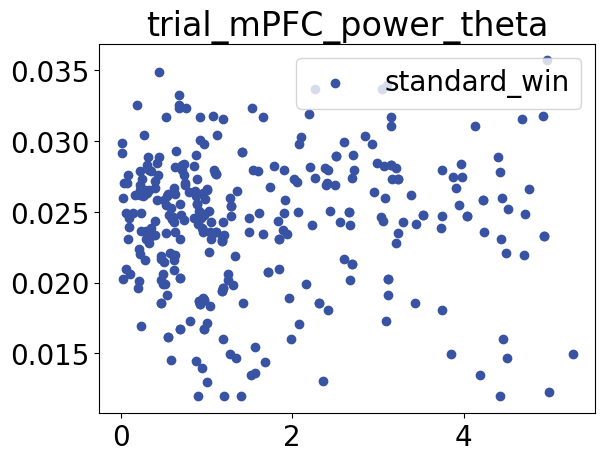

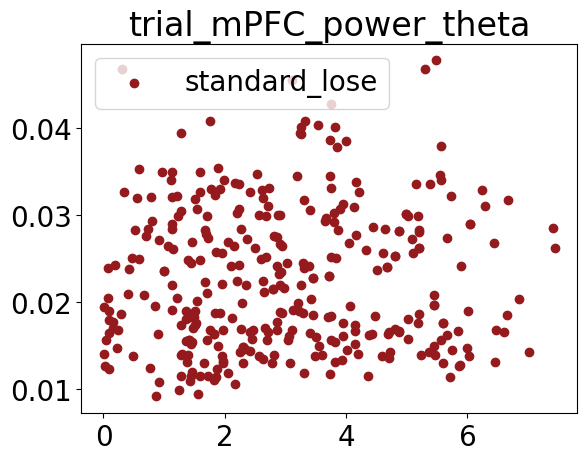

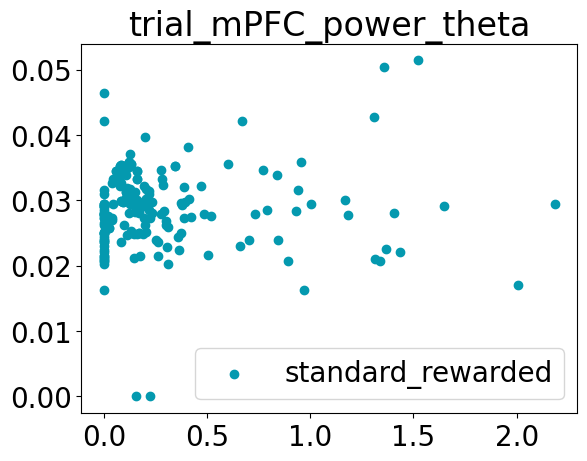

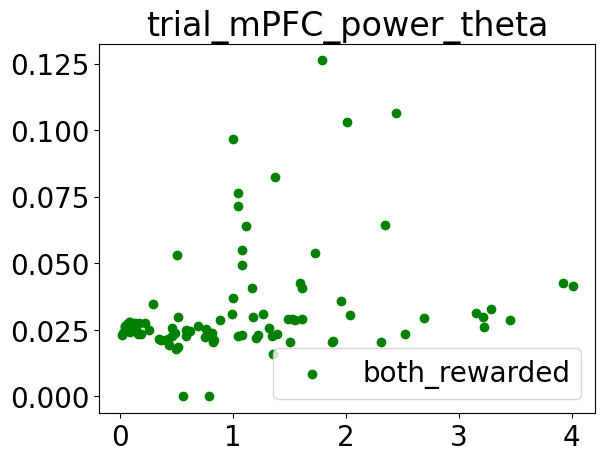

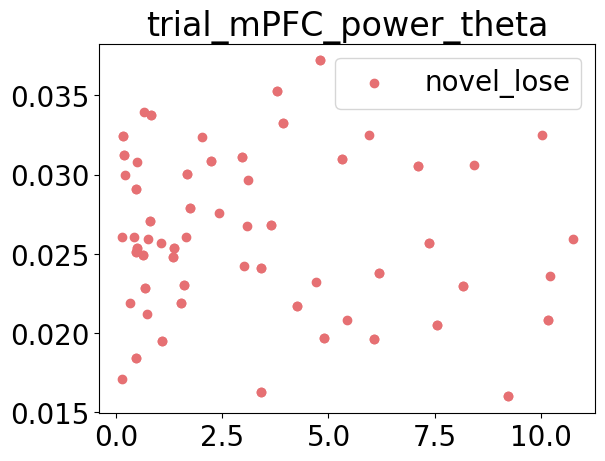

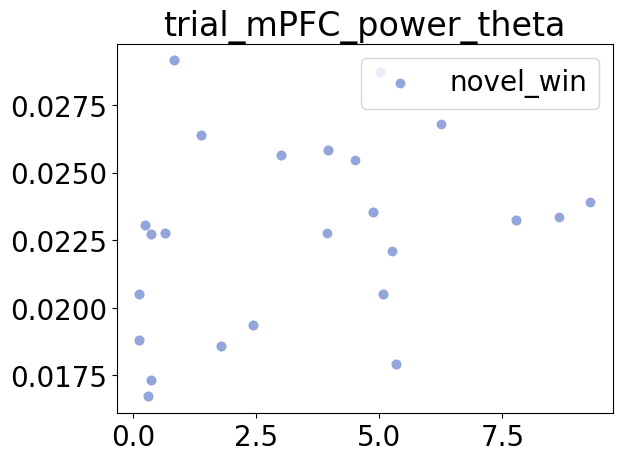

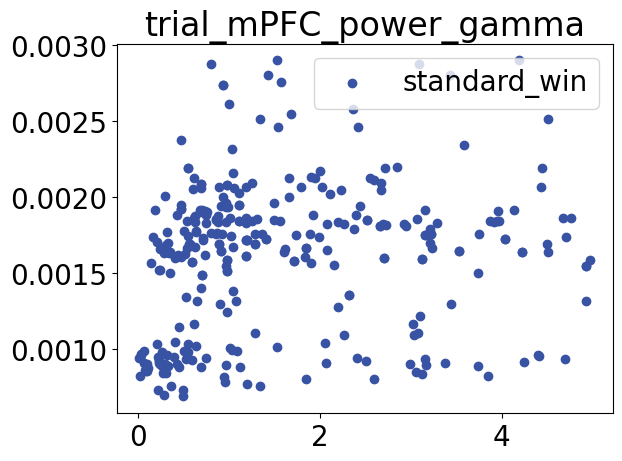

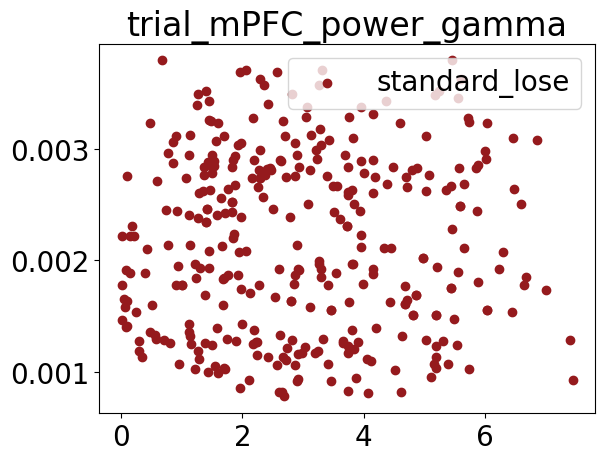

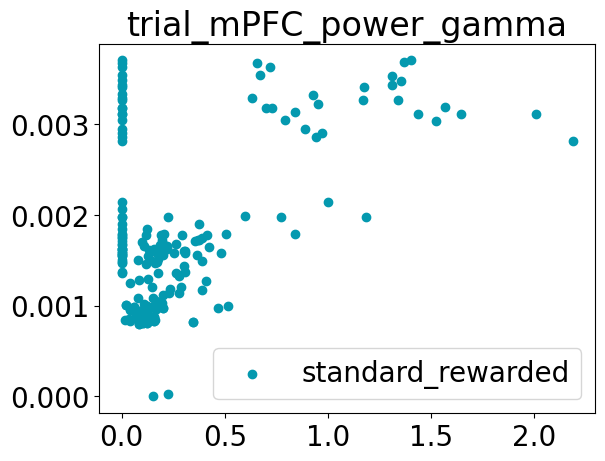

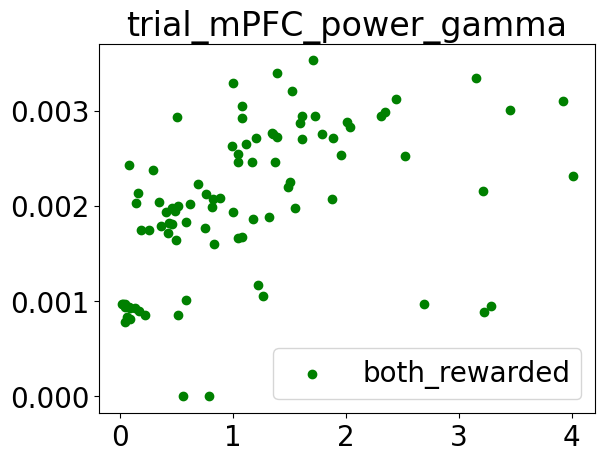

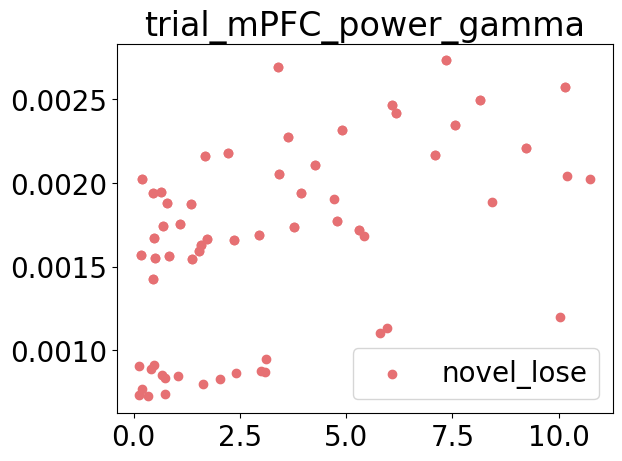

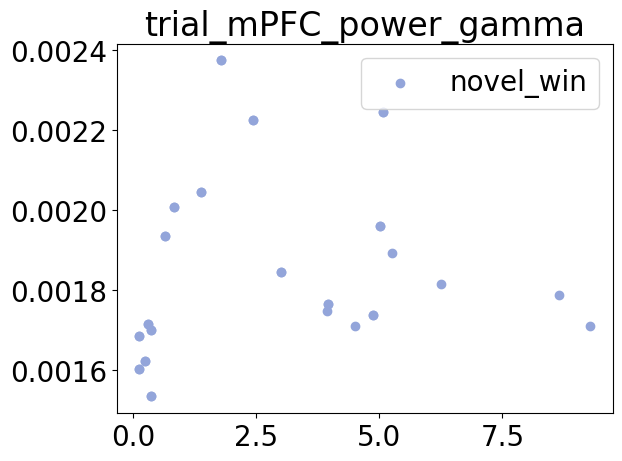

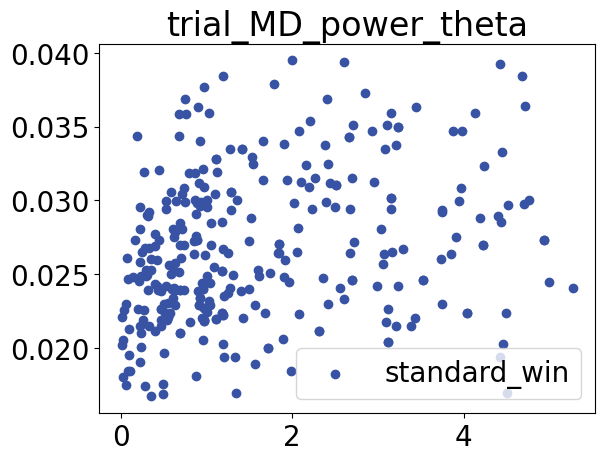

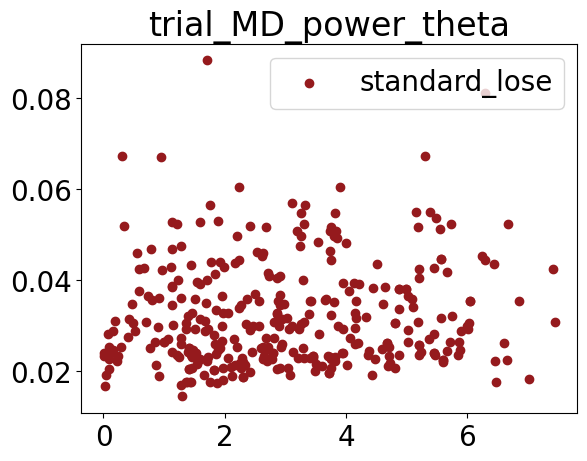

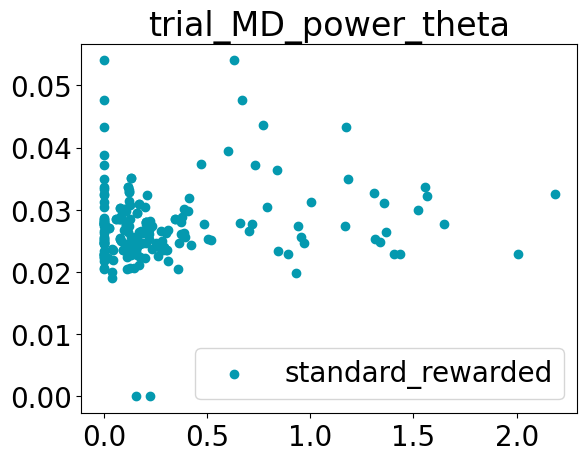

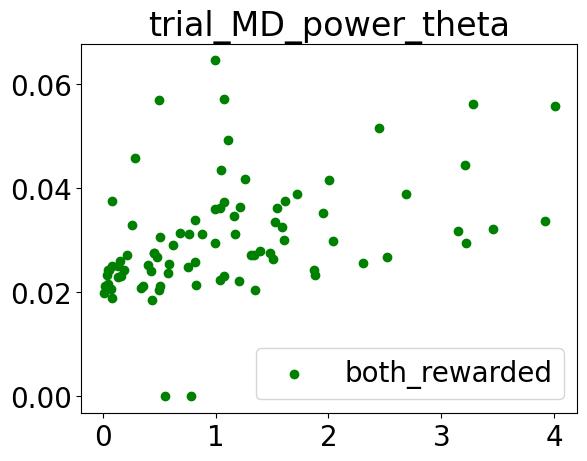

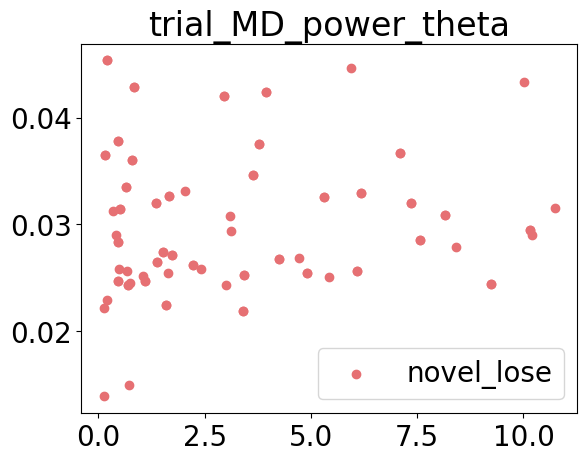

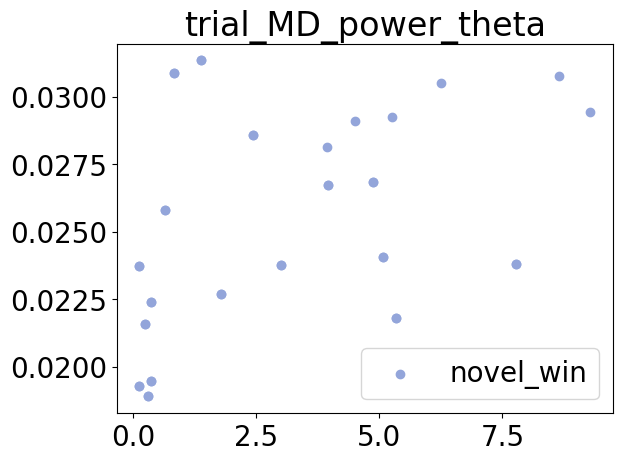

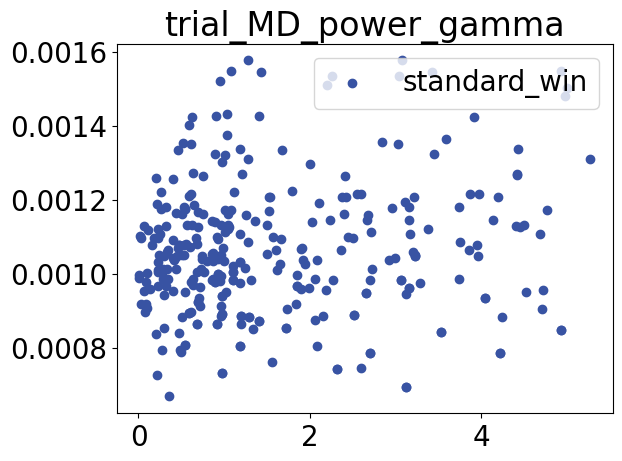

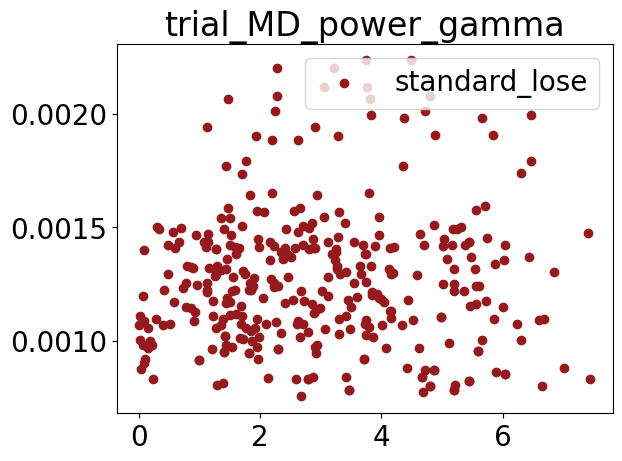

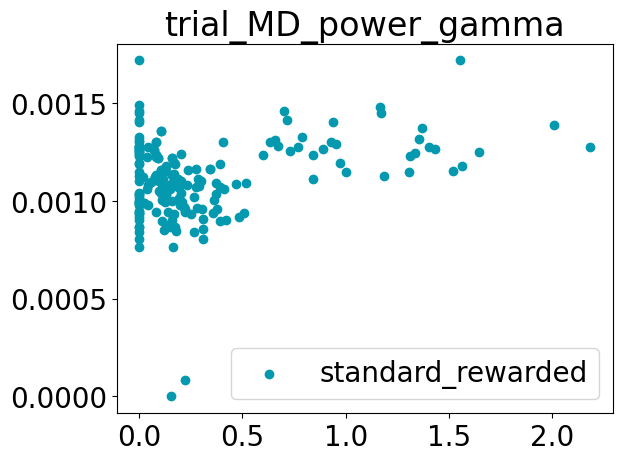

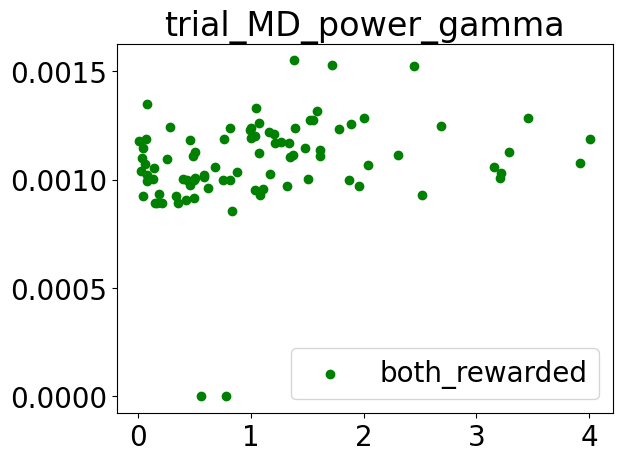

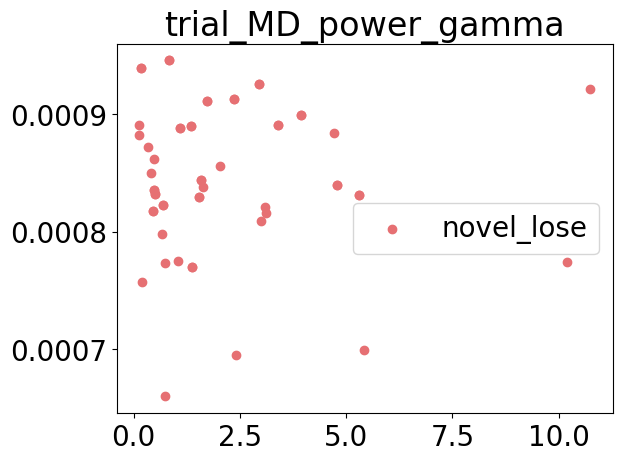

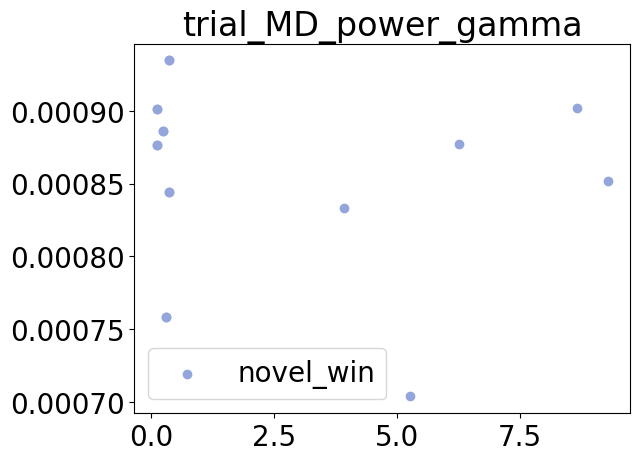

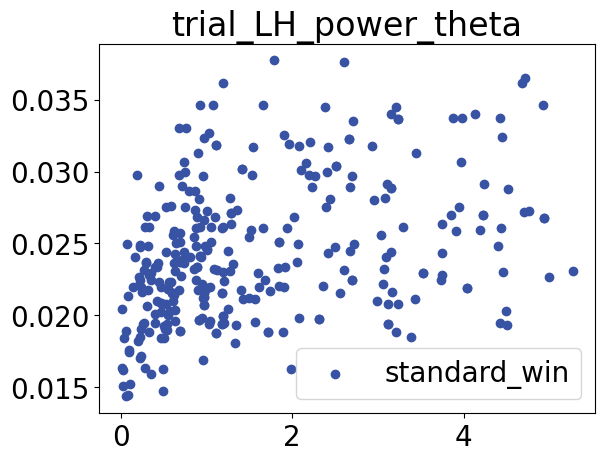

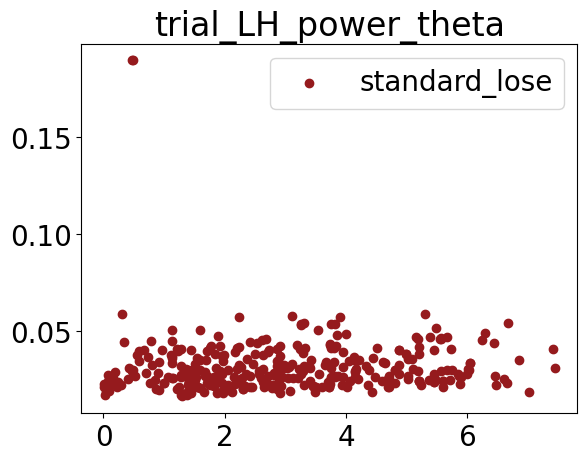

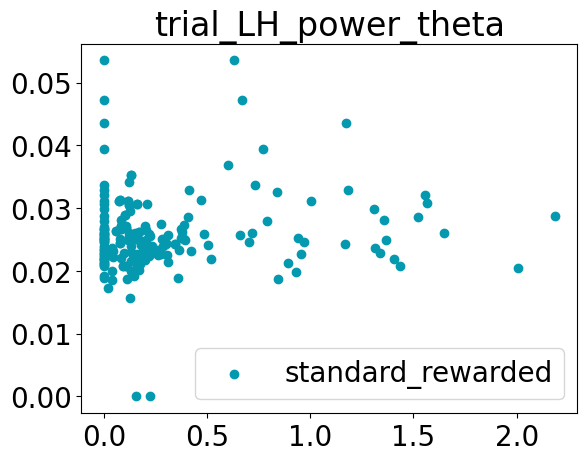

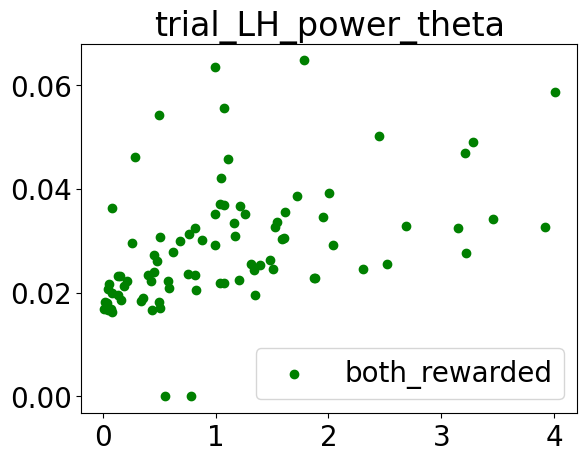

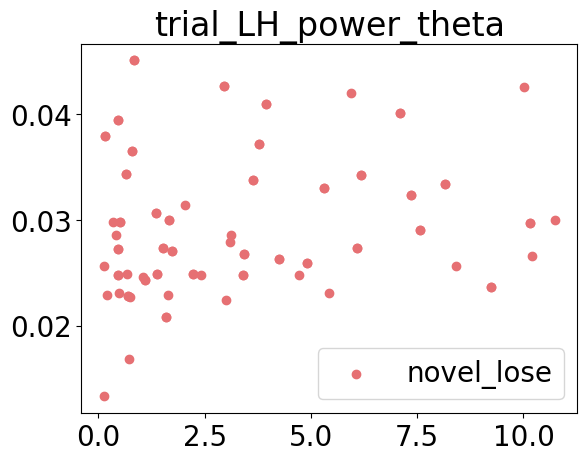

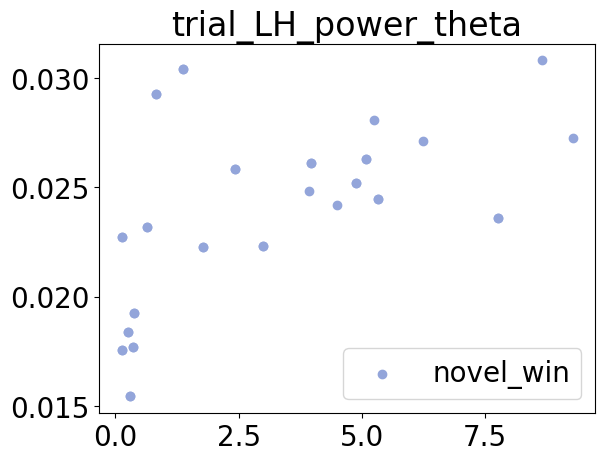

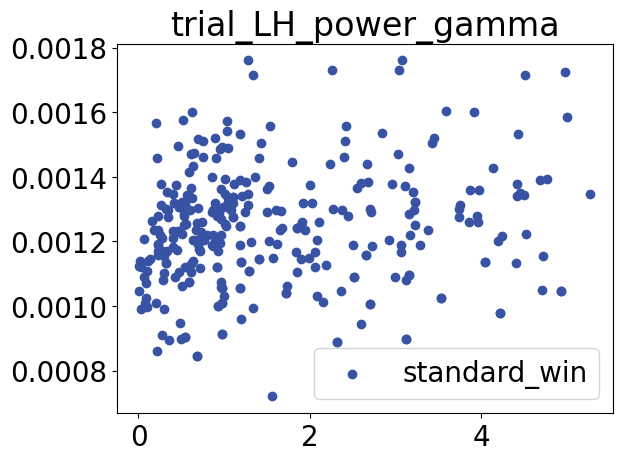

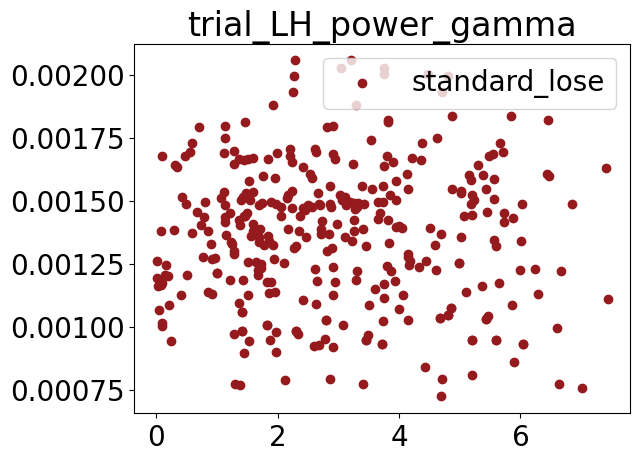

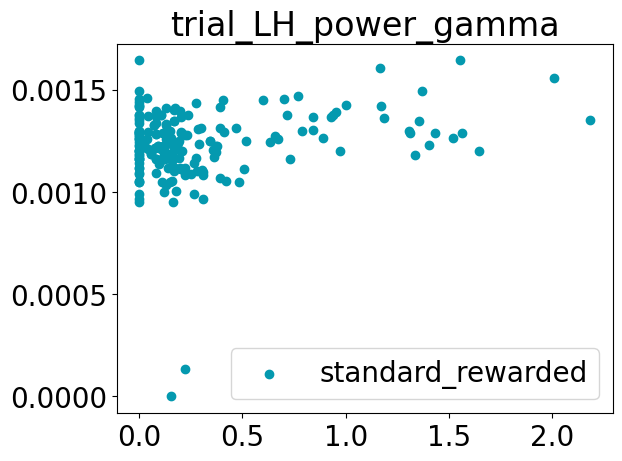

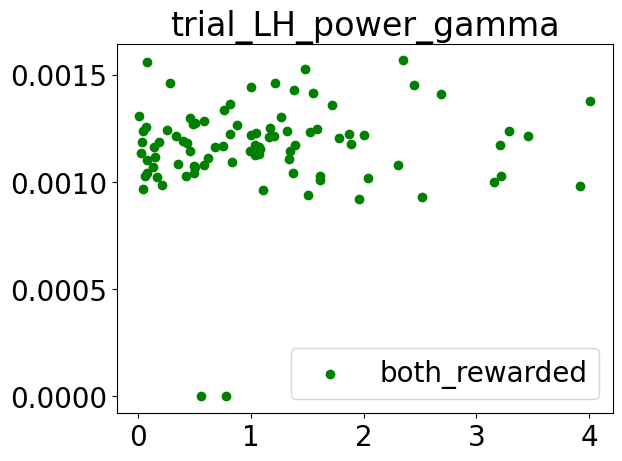

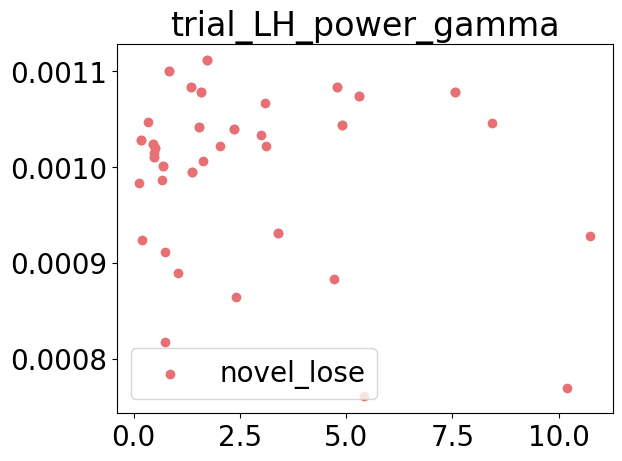

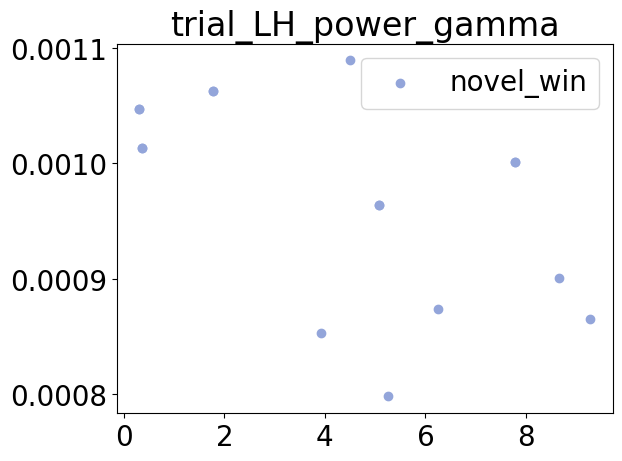

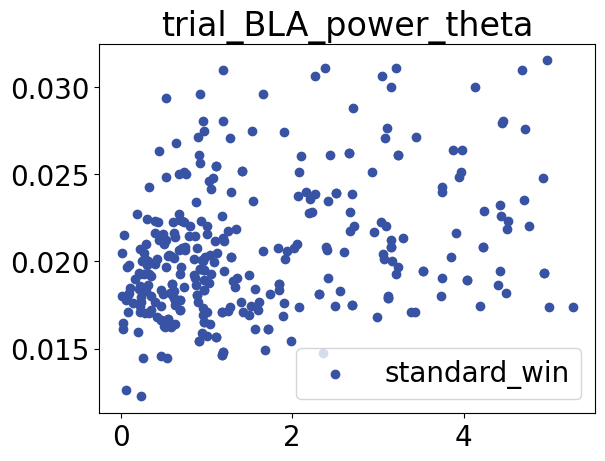

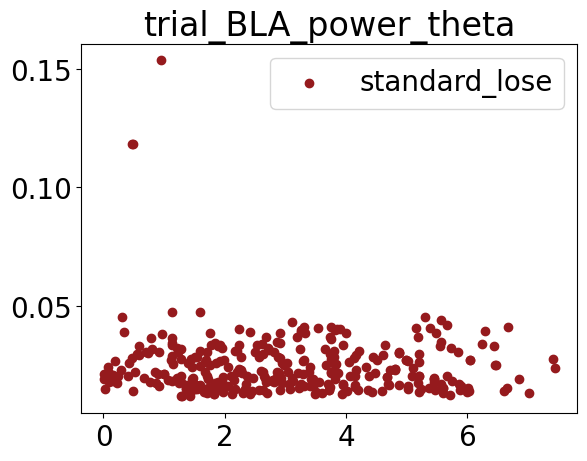

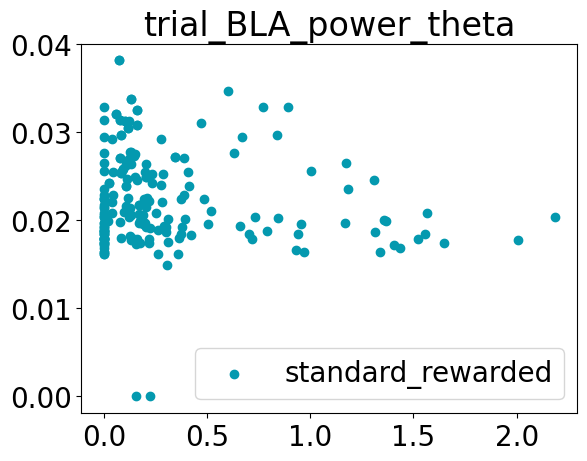

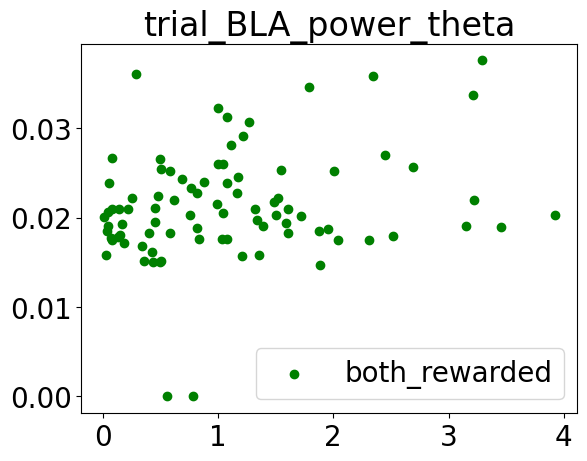

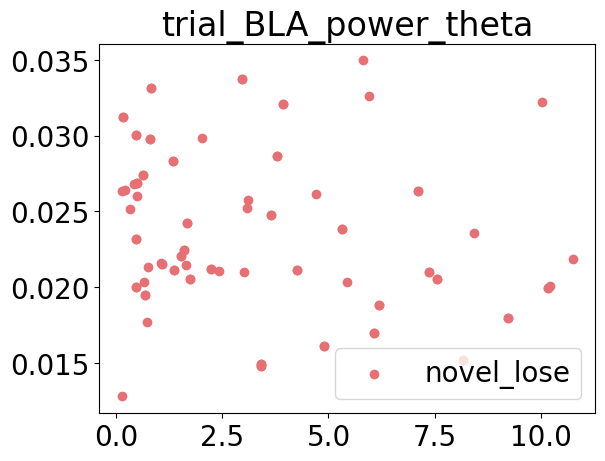

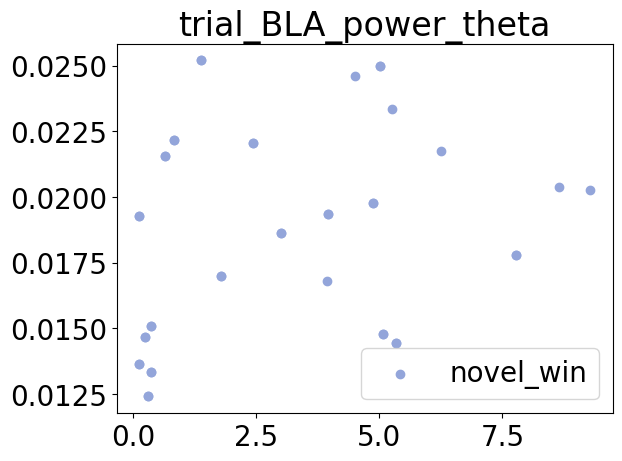

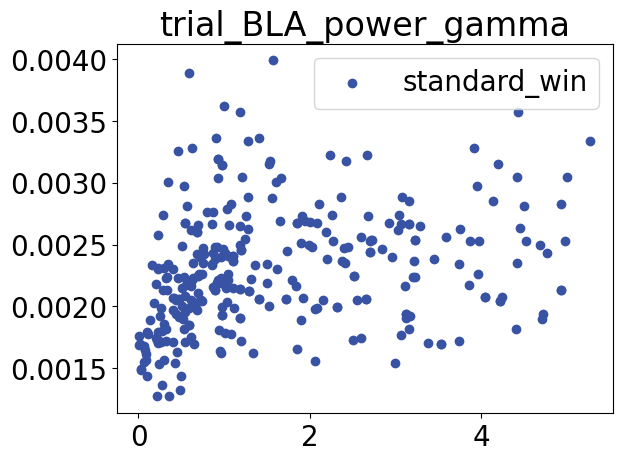

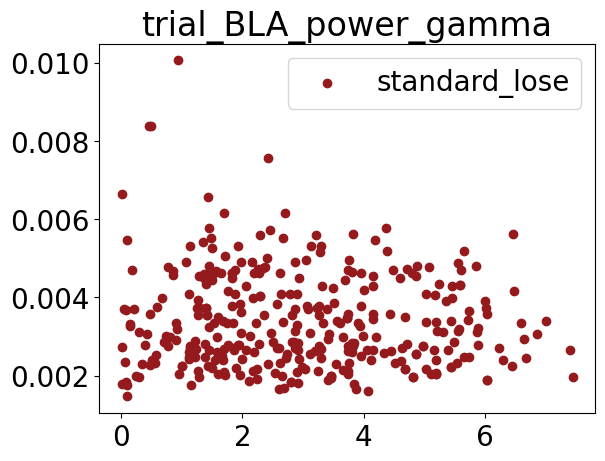

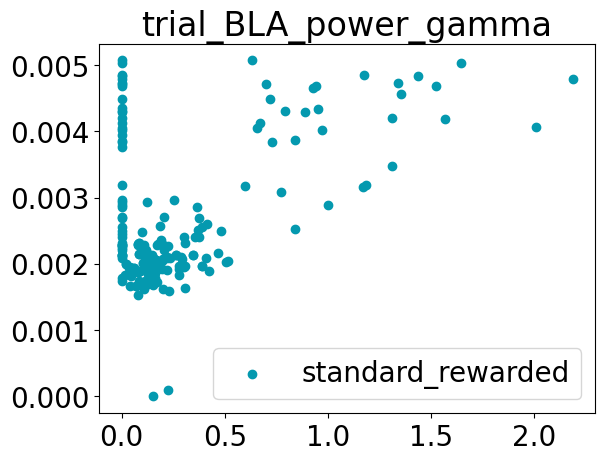

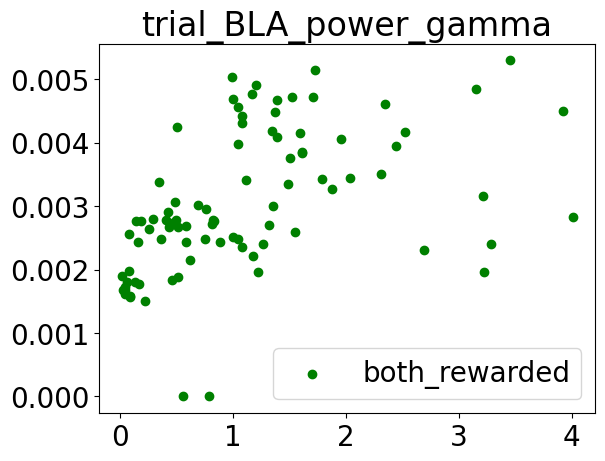

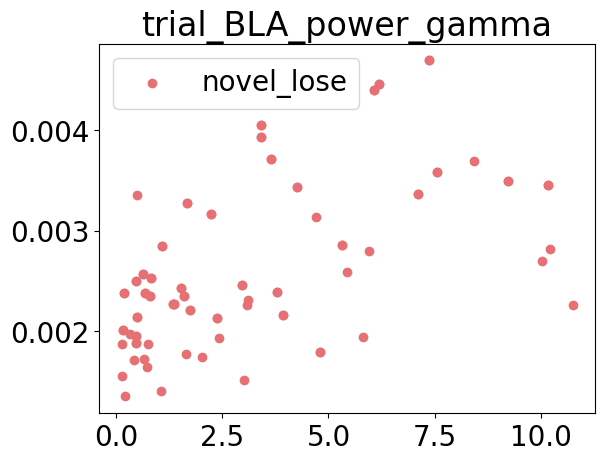

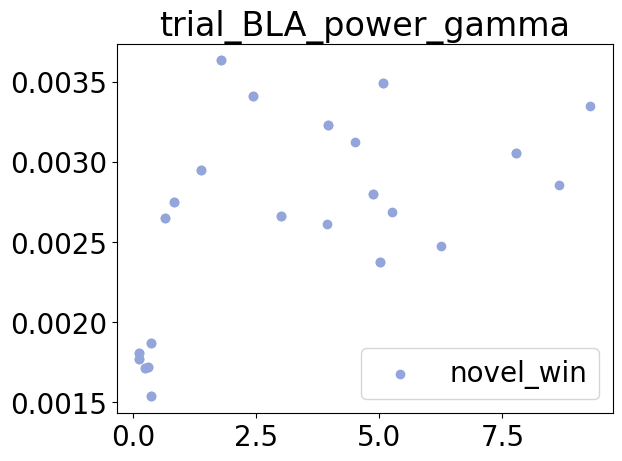

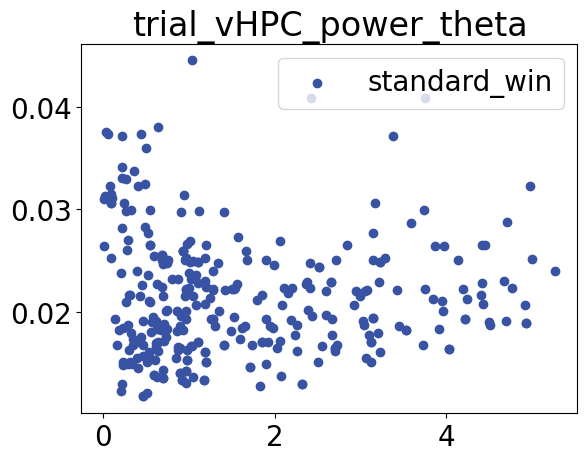

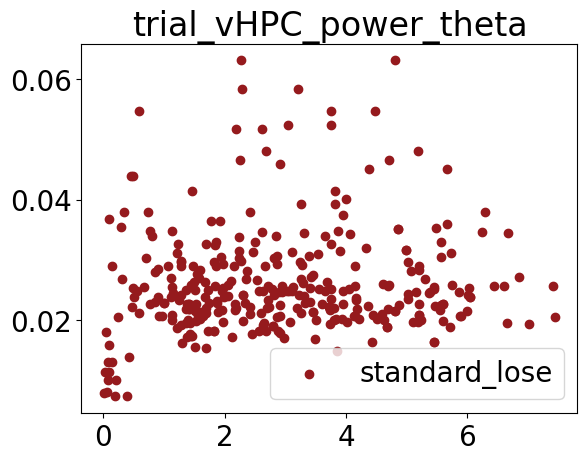

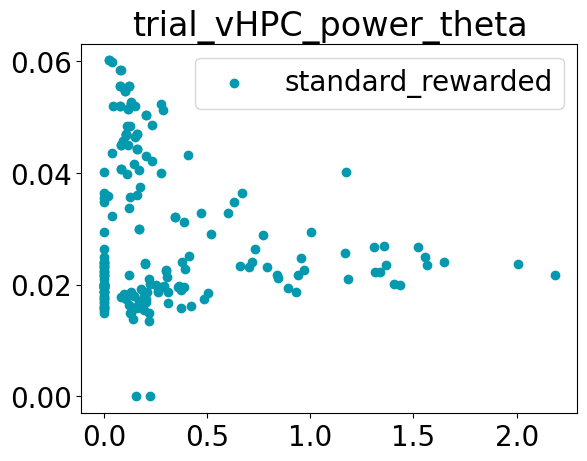

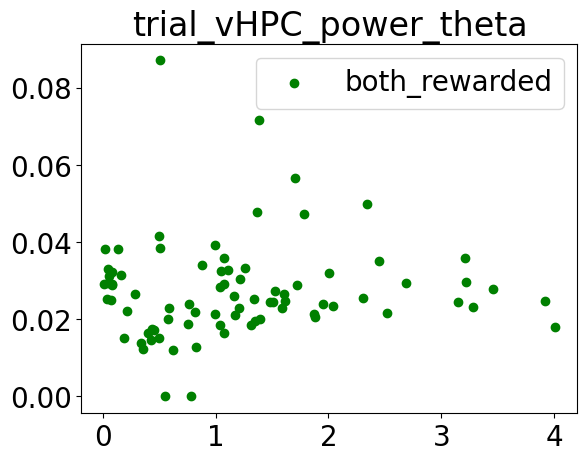

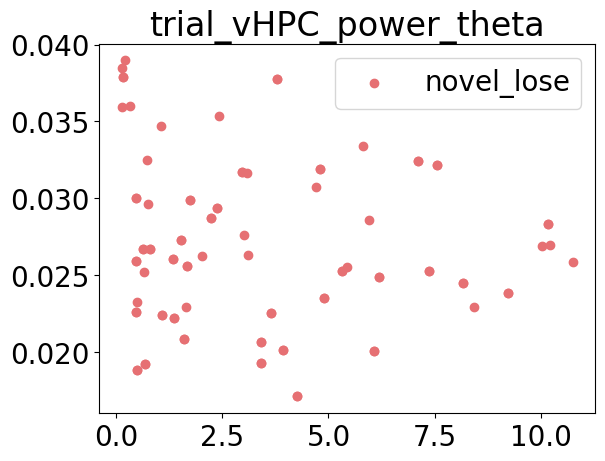

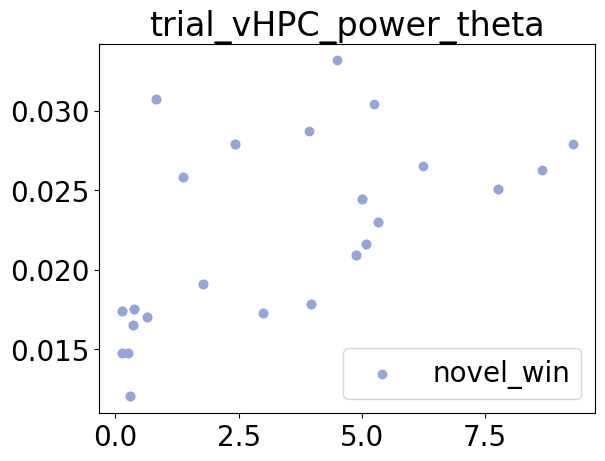

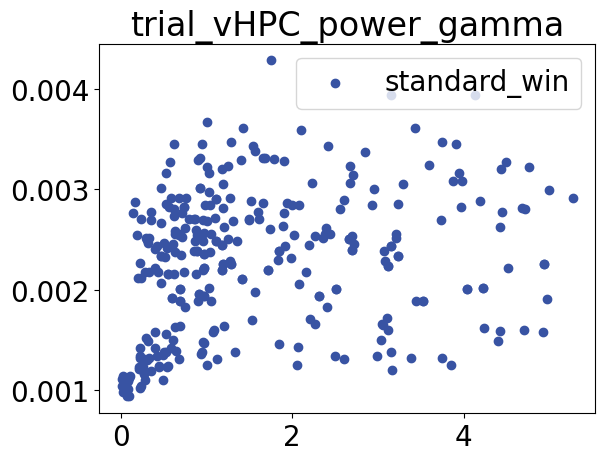

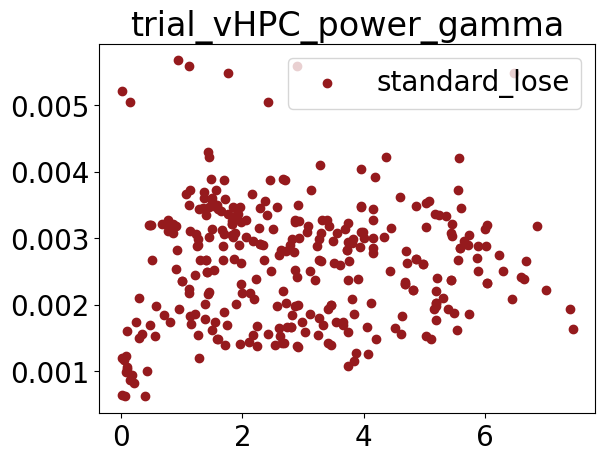

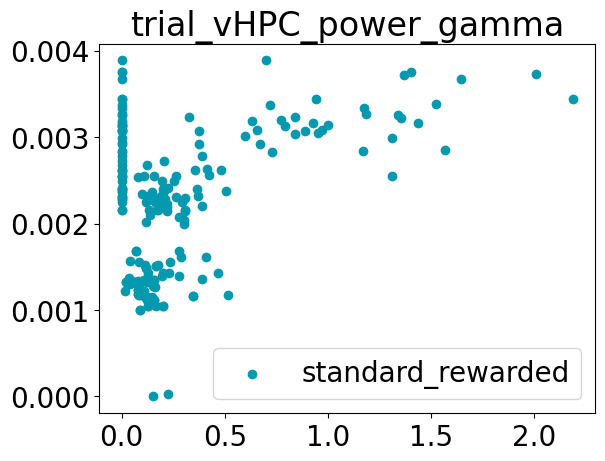

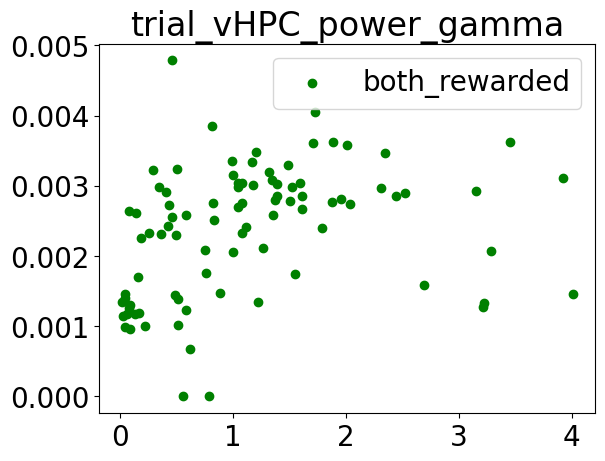

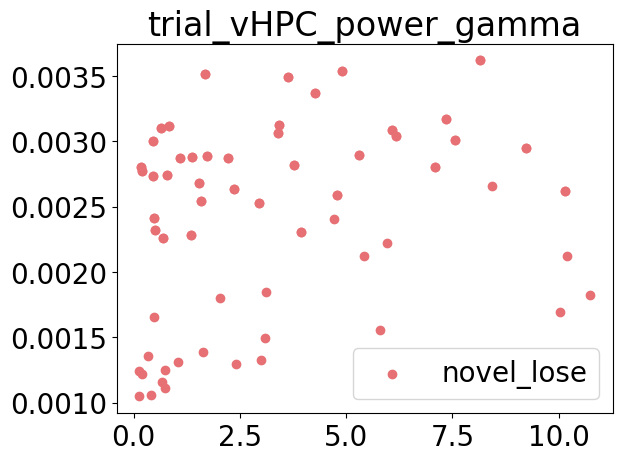

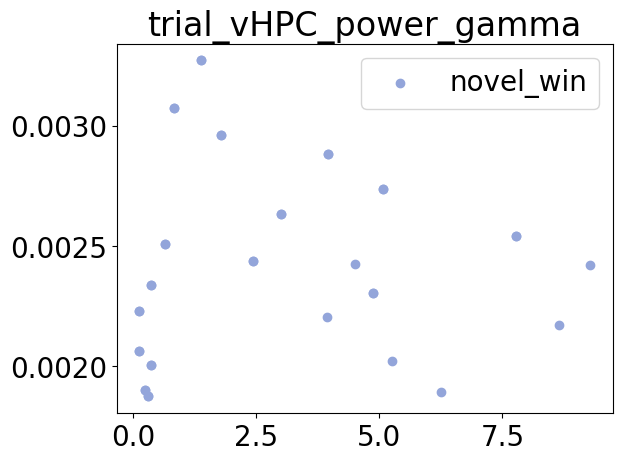

In [68]:
for power_col in power_columns:
    for trial_label in LFP_SPECTRAL_DF["experiment_and_label"].unique():
        trial_rows = LFP_SPECTRAL_DF[LFP_SPECTRAL_DF["experiment_and_label"] == trial_label]
        trial_rows[power_col] = trial_rows[power_col].apply(lambda x: np.nanmean(x))
        trial_rows["baseline_subject_thorax_velocity"] = trial_rows["baseline_subject_thorax_velocity"].apply(lambda x: np.nanmean(x))
        trial_rows["trial_subject_thorax_velocity"] = trial_rows["trial_subject_thorax_velocity"].apply(lambda x: np.nanmean(x))
        
        # Identify outliers as students with a z-score greater than 3
        threshold = 2
        trial_rows["power_z"] = stats.zscore(trial_rows[power_col], nan_policy='omit')
        trial_rows["baseline_z"] = stats.zscore(trial_rows["baseline_subject_thorax_velocity"], nan_policy='omit')
        trial_rows["trial_z"] = stats.zscore(trial_rows["trial_subject_thorax_velocity"], nan_policy='omit')
        
        trial_rows = trial_rows[(trial_rows["power_z"] < threshold) & (trial_rows["baseline_z"] < threshold) & (trial_rows["trial_z"] < threshold)]
        
        if "baseline" in power_col:
            continue
            # trial_rows = trial_rows[(np.abs(stats.zscore(trial_rows[[power_col, "baseline_subject_thorax_velocity"]])) < 3).all(axis=1)]
            fig, ax = plt.subplots()
            plt.title(power_col)
            # print(trial_rows["baseline_subject_thorax_velocity"])
            plt.scatter(trial_rows["baseline_subject_thorax_velocity"], trial_rows[power_col], label=trial_label, color=OUTCOME_TO_COLOR[trial_label])
            plt.legend()
            plt.show()
        
            continue
        elif "trial" in power_col:
            # trial_rows = trial_rows[(np.abs(stats.zscore(trial_rows[[power_col, "trial_subject_thorax_velocity"]])) < 3).all(axis=1)]
            fig, ax = plt.subplots()
            plt.title(power_col)
            plt.scatter(trial_rows["trial_subject_thorax_velocity"], trial_rows[power_col], label=trial_label, color=OUTCOME_TO_COLOR[trial_label])
            plt.legend()
            plt.show()

            continue

    # break

In [ ]:
trial_rows["power_z"]

In [ ]:
trial_rows[(power_z < threshold)]

In [ ]:
power_z < threshold

In [ ]:
for col in LFP_SPECTRAL_DF.columns:
    print(col)

In [ ]:
data_columns = [col for col in LFP_SPECTRAL_DF if "average" in col and "gamma" not in col and "theta" not in col]

In [ ]:
data_columns

In [ ]:
OUTCOME_TO_COLOR = {"both_rewarded_both_rewarded": "green", 
"novel_lose": "#e67073",
"novel_win": "#93a5da",
"standard_lose": "#951a1d",
"standard_rewarded": "#0499af",
"standard_win": "#3853a3"}

In [ ]:
BAND_TO_FREQ_PLOT = {'theta': (4, 12), 'gamma': (30, 50)}
BAND_TO_FREQ_COLOR = {'theta': "red", 'beta': "blue", 'gamma': "green"}

In [ ]:
all_column_suffixes = set([col.replace("baseline_", "").replace("trial_", "").replace("both_", "") for col in LFP_SPECTRAL_DF.columns if "power" in col or "granger" in col or "coherence" in col and "freq" not in col and "time" not in col])

In [ ]:
suffix_to_all_columns = {key: [col for col in LFP_SPECTRAL_DF if col.endswith(key)] for key in all_column_suffixes}

In [ ]:
LFP_SPECTRAL_DF["video_name"]

In [ ]:
# Define a function to horizontally stack arrays
def stack_arrays(arrays):
    return np.vstack(arrays)

## Plotting for standard

In [ ]:
standard_df = LFP_SPECTRAL_DF[LFP_SPECTRAL_DF["video_name"].str.contains("training")].copy()

In [ ]:


# Apply the function to each group and each column
grouped_all_trials_df = standard_df.groupby('experiment_and_label').agg({col: stack_arrays for col in data_columns})


In [ ]:
grouped_all_trials_df = pd.DataFrame(grouped_all_trials_df).reset_index()

In [ ]:
averaged_suffixed_to_col = {k: v for k,v in suffix_to_all_columns.items() if "averaged" in k}

In [ ]:
grouped_all_trials_df

In [ ]:
low_freq = 0
high_freq = 101

for suffix, columns in averaged_suffixed_to_col.items():
    if "theta" in suffix or "gamma" in suffix:
        continue
    fig, ax = plt.subplots()
    print(columns)
    trial_column = sorted(columns)[2]
    baseline_column = sorted(columns)[0]
    
    current_frequencies = range(low_freq, high_freq)

    plt.title("{}".format(suffix.replace("_averaged", "")))
    plt.xlabel("Frequency (Hz)", fontsize=FONTSIZE)
    plt.ylabel("a.u.", fontsize=FONTSIZE)
    plt.xlim(low_freq, high_freq) 
    if "power" in suffix:
        plt.yscale("log")
    else:
        plt.ylim(0, 1)
    
    for index, row in grouped_all_trials_df.iterrows():   
        #### DURING TRIAL ####
        mean_power = np.nanmean(row[trial_column], axis=0)
        nans, x= nan_helper(mean_power)
        mean_power[nans]= np.interp(x(nans), x(~nans), mean_power[~nans])
        sem_power = np.nanstd(row[trial_column], axis=0) / (row[trial_column].shape[0]**0.5)
        nans, x= nan_helper(sem_power)
        sem_power[nans]= np.interp(x(nans), x(~nans), sem_power[~nans])        
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="trial {}".format(row["experiment_and_label"]), linewidth=5, linestyle="-", color=OUTCOME_TO_COLOR[row["experiment_and_label"]])

            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=OUTCOME_TO_COLOR[row["experiment_and_label"]])
        except Exception as e: 
            print(e)
            pass
        #### BASELINE ####
        mean_power = np.nanmean(row[baseline_column], axis=0)
        nans, x= nan_helper(mean_power)
        mean_power[nans]= np.interp(x(nans), x(~nans), mean_power[~nans])
        sem_power = np.nanstd(row[baseline_column], axis=0) / (row[baseline_column].shape[0]**0.5)
        nans, x= nan_helper(sem_power)
        sem_power[nans]= np.interp(x(nans), x(~nans), sem_power[~nans])        
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="baseline {}".format(row["experiment_and_label"]), linewidth=5, linestyle=":", color=OUTCOME_TO_COLOR[row["experiment_and_label"]])

            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=OUTCOME_TO_COLOR[row["experiment_and_label"]])
        except Exception as e: 
            print(e)
            pass    
    
    for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
        ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.1, label=band)
    
    plt.legend(fontsize=10, ncol=2)
    # ax.get_legend().remove()
    plt.tight_layout()

    # plt.show()
    plt.savefig("./proc/plots/spectra/standard_{}_spectra.png".format(suffix))
               

## Plotting for novel

In [ ]:
novel_df = LFP_SPECTRAL_DF[LFP_SPECTRAL_DF["video_name"].str.contains("novel")].copy()

In [ ]:


# Apply the function to each group and each column
grouped_all_trials_df = novel_df.groupby('experiment_and_label').agg({col: stack_arrays for col in data_columns})


In [ ]:
grouped_all_trials_df = pd.DataFrame(grouped_all_trials_df).reset_index()

In [ ]:
averaged_suffixed_to_col = {k: v for k,v in suffix_to_all_columns.items() if "averaged" in k}

In [ ]:
grouped_all_trials_df

In [ ]:
low_freq = 0
high_freq = 101

for suffix, columns in averaged_suffixed_to_col.items():
    if "theta" in suffix or "gamma" in suffix:
        continue
    fig, ax = plt.subplots()
    print(columns)
    trial_column = sorted(columns)[2]
    baseline_column = sorted(columns)[0]
    
    current_frequencies = range(low_freq, high_freq)

    plt.title("{}".format(suffix.replace("_averaged", "")))
    plt.xlabel("Frequency (Hz)", fontsize=FONTSIZE)
    plt.ylabel("a.u.", fontsize=FONTSIZE)
    plt.xlim(low_freq, high_freq) 
    if "power" in suffix:
        plt.yscale("log")
    else:
        plt.ylim(0, 1)
    
    for index, row in grouped_all_trials_df.iterrows():   
        #### DURING TRIAL ####
        mean_power = np.nanmean(row[trial_column], axis=0)
        nans, x= nan_helper(mean_power)
        mean_power[nans]= np.interp(x(nans), x(~nans), mean_power[~nans])
        sem_power = np.nanstd(row[trial_column], axis=0) / (row[trial_column].shape[0]**0.5)
        nans, x= nan_helper(sem_power)
        sem_power[nans]= np.interp(x(nans), x(~nans), sem_power[~nans])        
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="trial {}".format(row["experiment_and_label"]), linewidth=5, linestyle="-", color=OUTCOME_TO_COLOR[row["experiment_and_label"]])

            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=OUTCOME_TO_COLOR[row["experiment_and_label"]])
        except Exception as e: 
            print(e)
            pass
        #### BASELINE ####
        mean_power = np.nanmean(row[baseline_column], axis=0)
        nans, x= nan_helper(mean_power)
        mean_power[nans]= np.interp(x(nans), x(~nans), mean_power[~nans])
        sem_power = np.nanstd(row[baseline_column], axis=0) / (row[baseline_column].shape[0]**0.5)
        nans, x= nan_helper(sem_power)
        sem_power[nans]= np.interp(x(nans), x(~nans), sem_power[~nans])        
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="baseline {}".format(row["experiment_and_label"]), linewidth=5, linestyle=":", color=OUTCOME_TO_COLOR[row["experiment_and_label"]])

            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=OUTCOME_TO_COLOR[row["experiment_and_label"]])
        except Exception as e: 
            print(e)
            pass    
    
    for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
        ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.1, label=band)
    
    plt.legend(fontsize=10, ncol=2)
    # ax.get_legend().remove()
    plt.tight_layout()

    # plt.show()
    plt.savefig("./proc/plots/spectra/novel_{}_spectra.png".format(suffix))
               

## Plotting for both rewarded/

In [ ]:
both_df = LFP_SPECTRAL_DF[LFP_SPECTRAL_DF["video_name"].str.contains("both")].copy()

In [ ]:


# Apply the function to each group and each column
grouped_all_trials_df = both_df.groupby('experiment_and_label').agg({col: stack_arrays for col in data_columns})


In [ ]:
grouped_all_trials_df = pd.DataFrame(grouped_all_trials_df).reset_index()

In [ ]:
averaged_suffixed_to_col = {k: v for k,v in suffix_to_all_columns.items() if "averaged" in k}

In [ ]:
grouped_all_trials_df

In [ ]:
low_freq = 0
high_freq = 101

for suffix, columns in averaged_suffixed_to_col.items():
    if "theta" in suffix or "gamma" in suffix:
        continue
    fig, ax = plt.subplots()
    print(columns)
    trial_column = sorted(columns)[2]
    baseline_column = sorted(columns)[0]
    
    current_frequencies = range(low_freq, high_freq)

    plt.title("{}".format(suffix.replace("_averaged", "")))
    plt.xlabel("Frequency (Hz)", fontsize=FONTSIZE)
    plt.ylabel("a.u.", fontsize=FONTSIZE)
    plt.xlim(low_freq, high_freq) 
    if "power" in suffix:
        plt.yscale("log")
    else:
        plt.ylim(0, 1)
    
    for index, row in grouped_all_trials_df.iterrows():   
        #### DURING TRIAL ####
        mean_power = np.nanmean(row[trial_column], axis=0)
        nans, x= nan_helper(mean_power)
        mean_power[nans]= np.interp(x(nans), x(~nans), mean_power[~nans])
        sem_power = np.nanstd(row[trial_column], axis=0) / (row[trial_column].shape[0]**0.5)
        nans, x= nan_helper(sem_power)
        sem_power[nans]= np.interp(x(nans), x(~nans), sem_power[~nans])        
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="trial {}".format(row["experiment_and_label"]), linewidth=5, linestyle="-", color=OUTCOME_TO_COLOR[row["experiment_and_label"]])

            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=OUTCOME_TO_COLOR[row["experiment_and_label"]])
        except Exception as e: 
            print(e)
            pass
        #### BASELINE ####
        mean_power = np.nanmean(row[baseline_column], axis=0)
        nans, x= nan_helper(mean_power)
        mean_power[nans]= np.interp(x(nans), x(~nans), mean_power[~nans])
        sem_power = np.nanstd(row[baseline_column], axis=0) / (row[baseline_column].shape[0]**0.5)
        nans, x= nan_helper(sem_power)
        sem_power[nans]= np.interp(x(nans), x(~nans), sem_power[~nans])        
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="baseline {}".format(row["experiment_and_label"]), linewidth=5, linestyle=":", color=OUTCOME_TO_COLOR[row["experiment_and_label"]])

            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=OUTCOME_TO_COLOR[row["experiment_and_label"]])
        except Exception as e: 
            print(e)
            pass    
    
    for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
        ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.1, label=band)
    
    plt.legend(fontsize=8, ncol=2)
    # ax.get_legend().remove()
    plt.tight_layout()

    # plt.show()
    plt.savefig("./proc/plots/spectra/both_{}_spectra.png".format(suffix))
               

## PLotting bar plots

In [ ]:
band_columns = [col for col in LFP_SPECTRAL_DF if "beta" in col or "gamma" in col and "averaged" in col]

In [ ]:
band_columns

In [ ]:
data_columns = [col for col in LFP_SPECTRAL_DF if "average" in col and ("gamma" in col or "theta" in col) and "both" not in col]


### Plotting standard bar plots 

In [ ]:
standard_df = LFP_SPECTRAL_DF[LFP_SPECTRAL_DF["video_name"].str.contains("training")].copy()

In [ ]:
data_columns

In [ ]:

#lol
# Apply the function to each group and each column
# grouped_all_trials_df = standard_df.groupby('experiment_and_label')[data_columns].apply(lambda x: np.array(x).astype(np.float16)).reset_index()


grouped_all_trials_df = standard_df.groupby('experiment_and_label').agg({col: list for col in data_columns}).apply(lambda x: np.array(x))


In [ ]:
grouped_all_trials_df = pd.DataFrame(grouped_all_trials_df).reset_index()

In [ ]:
grouped_all_trials_df.head()

In [ ]:
averaged_suffixed_to_col = {k: sorted(v) for k,v in suffix_to_all_columns.items() if "averaged" in k and ("beta" in k or "gamma" in k)}


In [ ]:
averaged_suffixed_to_col

In [ ]:
grouped_all_trials_df

In [ ]:
trial_column

In [ ]:
for suffix, columns in averaged_suffixed_to_col.items():
    fig, ax = plt.subplots()
    print(columns)
    trial_column = sorted(columns)[2]
    baseline_column = sorted(columns)[0]

    plt.title(" ".join(suffix.split("_")).replace("gamma", "\ngamma").replace("theta", "\ntheta"))
    
    if "power" in suffix:
        # plt.yscale("log")
        pass
    else:
        plt.ylim(0, 1)
    
    for index, row in grouped_all_trials_df.iterrows():
        mean_power = np.nanmean(row[trial_column])

        sem_power = np.nanstd(row[trial_column]) / (len(row[trial_column])**0.5)

        plt.bar(row["experiment_and_label"].split("_")[-1] + "\ntrial", mean_power, color = OUTCOME_TO_COLOR[row["experiment_and_label"]])
        plt.errorbar(row["experiment_and_label"].split("_")[-1] + "\ntrial", mean_power, yerr=sem_power, fmt="o", color="black")
    
    for index, row in grouped_all_trials_df.iterrows():
        mean_power = np.nanmean(row[baseline_column])

        sem_power = np.nanstd(row[baseline_column]) / (len(row[baseline_column])**0.5)

        plt.bar(row["experiment_and_label"].split("_")[-1] + "\nbaseline", mean_power, color = OUTCOME_TO_COLOR[row["experiment_and_label"]])
        plt.errorbar(row["experiment_and_label"].split("_")[-1] + "\nbaseline", mean_power, yerr=sem_power, fmt="o", color="black")

    
    plt.ylabel("a.u.")
    plt.xticks(rotation=90)
    # plt.tight_layout()

    # plt.show()
    plt.savefig("./proc/plots/bar/standard_{}_bar.png".format(suffix))



### Plotting novel bar plots 

In [ ]:
novel_df = LFP_SPECTRAL_DF[LFP_SPECTRAL_DF["video_name"].str.contains("novel")].copy()

In [ ]:
data_columns

In [ ]:

#lol
# Apply the function to each group and each column
# grouped_all_trials_df = standard_df.groupby('experiment_and_label')[data_columns].apply(lambda x: np.array(x).astype(np.float16)).reset_index()


grouped_all_trials_df = novel_df.groupby('experiment_and_label').agg({col: list for col in data_columns}).apply(lambda x: np.array(x))


In [ ]:
grouped_all_trials_df = pd.DataFrame(grouped_all_trials_df).reset_index()

In [ ]:
grouped_all_trials_df.head()

In [ ]:
averaged_suffixed_to_col = {k: sorted(v) for k,v in suffix_to_all_columns.items() if "averaged" in k and ("beta" in k or "gamma" in k)}


In [ ]:
averaged_suffixed_to_col

In [ ]:
grouped_all_trials_df

In [ ]:
for suffix, columns in averaged_suffixed_to_col.items():
    fig, ax = plt.subplots()
    print(columns)
    trial_column = sorted(columns)[2]
    baseline_column = sorted(columns)[0]

    plt.title(" ".join(suffix.split("_")).replace("gamma", "\ngamma").replace("theta", "\ntheta"))
    
    if "power" in suffix:
        # plt.yscale("log")
        pass
    else:
        plt.ylim(0, 1)
    
    for index, row in grouped_all_trials_df.iterrows():
        mean_power = np.nanmean(row[trial_column])

        sem_power = np.nanstd(row[trial_column]) / (len(row[trial_column])**0.5)

        plt.bar(row["experiment_and_label"] + "\ntrial", mean_power, color = OUTCOME_TO_COLOR[row["experiment_and_label"]])
        plt.errorbar(row["experiment_and_label"] + "\ntrial", mean_power, yerr=sem_power, fmt="o", color="black")
    
    for index, row in grouped_all_trials_df.iterrows():
        mean_power = np.nanmean(row[baseline_column])

        sem_power = np.nanstd(row[baseline_column]) / (len(row[baseline_column])**0.5)

        plt.bar(row["experiment_and_label"] + "\nbaseline", mean_power, color = OUTCOME_TO_COLOR[row["experiment_and_label"]])
        plt.errorbar(row["experiment_and_label"] + "\nbaseline", mean_power, yerr=sem_power, fmt="o", color="black")

    
    plt.ylabel("a.u.")
    plt.xticks(rotation=90)
    # plt.tight_layout()

    # plt.show()
    plt.savefig("./proc/plots/bar/novel_{}_bar.png".format(suffix))



### Plotting both rewarded plots 

In [ ]:
both_df = LFP_SPECTRAL_DF[LFP_SPECTRAL_DF["video_name"].str.contains("both")].copy()

In [ ]:
data_columns

In [ ]:

#lol
# Apply the function to each group and each column
# grouped_all_trials_df = standard_df.groupby('experiment_and_label')[data_columns].apply(lambda x: np.array(x).astype(np.float16)).reset_index()


grouped_all_trials_df = both_df.groupby('experiment_and_label').agg({col: list for col in data_columns}).apply(lambda x: np.array(x))


In [ ]:
grouped_all_trials_df = pd.DataFrame(grouped_all_trials_df).reset_index()

In [ ]:
grouped_all_trials_df.head()

In [ ]:
averaged_suffixed_to_col = {k: sorted(v) for k,v in suffix_to_all_columns.items() if "averaged" in k and ("beta" in k or "gamma" in k)}


In [ ]:
averaged_suffixed_to_col

In [ ]:
grouped_all_trials_df

In [ ]:
for suffix, columns in averaged_suffixed_to_col.items():
    fig, ax = plt.subplots()
    print(columns)
    trial_column = sorted(columns)[2]
    baseline_column = sorted(columns)[0]

    plt.title(" ".join(suffix.split("_")).replace("gamma", "\ngamma").replace("theta", "\ntheta"))
    
    if "power" in suffix:
        # plt.yscale("log")
        pass
    else:
        plt.ylim(0, 1)
    
    for index, row in grouped_all_trials_df.iterrows():
        mean_power = np.nanmean(row[trial_column])

        sem_power = np.nanstd(row[trial_column]) / (len(row[trial_column])**0.5)

        plt.bar(row["experiment_and_label"].replace("_both_rewarded", "") + "\ntrial", mean_power, color = OUTCOME_TO_COLOR[row["experiment_and_label"]])
        plt.errorbar(row["experiment_and_label"].replace("_both_rewarded", "") + "\ntrial", mean_power, yerr=sem_power, fmt="o", color="black")
    
    for index, row in grouped_all_trials_df.iterrows():
        mean_power = np.nanmean(row[baseline_column])

        sem_power = np.nanstd(row[baseline_column]) / (len(row[baseline_column])**0.5)

        plt.bar(row["experiment_and_label"].replace("_both_rewarded", "") + "\nbaseline", mean_power, color = OUTCOME_TO_COLOR[row["experiment_and_label"]])
        plt.errorbar(row["experiment_and_label"].replace("_both_rewarded", "") + "\nbaseline", mean_power, yerr=sem_power, fmt="o", color="black")

    
    plt.ylabel("a.u.")
    plt.xticks(rotation=90)
    # plt.tight_layout()

    # plt.show()
    plt.savefig("./proc/plots/bar/both_{}_bar.png".format(suffix))



In [ ]:
    plt.title("{}".format(suffix.replace("_averaged", "")))
    
    
    # plt.xlabel("Frequency (Hz)", fontsize=FONTSIZE)
    # plt.ylabel("a.u.", fontsize=FONTSIZE)
    # plt.xlim(low_freq, high_freq) 
    # if "power" in suffix:
    #     plt.yscale("log")
    # else:
    #     plt.ylim(0, 1)
    
    
    
    for index, row in grouped_all_trials_df.iterrows():   
        #### DURING TRIAL ####
        mean_power = np.nanmean(row[trial_column], axis=0)
        nans, x= nan_helper(mean_power)
        mean_power[nans]= np.interp(x(nans), x(~nans), mean_power[~nans])
        sem_power = np.nanstd(row[trial_column], axis=0) / (row[trial_column].shape[0]**0.5)
        nans, x= nan_helper(sem_power)
        sem_power[nans]= np.interp(x(nans), x(~nans), sem_power[~nans])        
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="trial {}".format(row["experiment_and_label"]), linewidth=5, linestyle="-", color=OUTCOME_TO_COLOR[row["experiment_and_label"]])

            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=OUTCOME_TO_COLOR[row["experiment_and_label"]])
        except Exception as e: 
            print(e)
            pass
        #### BASELINE ####
        mean_power = np.nanmean(row[baseline_column], axis=0)
        nans, x= nan_helper(mean_power)
        mean_power[nans]= np.interp(x(nans), x(~nans), mean_power[~nans])
        sem_power = np.nanstd(row[baseline_column], axis=0) / (row[baseline_column].shape[0]**0.5)
        nans, x= nan_helper(sem_power)
        sem_power[nans]= np.interp(x(nans), x(~nans), sem_power[~nans])        
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="baseline {}".format(row["experiment_and_label"]), linewidth=5, linestyle=":", color=OUTCOME_TO_COLOR[row["experiment_and_label"]])

            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=OUTCOME_TO_COLOR[row["experiment_and_label"]])
        except Exception as e: 
            print(e)
            pass    
    
    for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
        ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.1, label=band)
    
    plt.legend(fontsize=10, ncol=2)
    # ax.get_legend().remove()
    plt.tight_layout()

    # plt.show()
    # plt.savefig("./proc/plots/spectra/standard_{}_spectra.png".format(suffix))
               

In [ ]:
LFP_SPECTRAL_DF

In [ ]:
raise ValueError()

In [ ]:
LFP_SPECTRAL_DF.columns

In [ ]:
LFP_SPECTRAL_DF["power_calculation_frequencies"]

In [ ]:
raise ValueError()

### Merging LFP Trace dataframe and SLEAP pose tracking

In [ ]:
merge_columns = ["time", "recording_file", "current_subject", "video_number"]
# Find columns in df2 that are not in merge_columns and also exist in df1, then drop them from df2
cols_to_drop = [col for col in CHANNEL_MAP_AND_ALL_TRIALS_DF.columns if col not in merge_columns and col in MERGED_TRIALS_AND_VIDEO.columns]
CHANNEL_MAP_AND_ALL_TRIALS_DF = CHANNEL_MAP_AND_ALL_TRIALS_DF.drop(columns=cols_to_drop)

In [ ]:
MERGED_LFP_AND_SLEAP = pd.merge(left=CHANNEL_MAP_AND_ALL_TRIALS_DF, right=MERGED_TRIALS_AND_VIDEO, on=merge_columns, how="right")

In [ ]:
MERGED_LFP_AND_SLEAP.head()

In [ ]:
trace_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "trace" in col]

In [ ]:
trial_trace_columns = sorted([col for col in MERGED_LFP_AND_SLEAP.columns if "trial_lfp_trace" in col])
baseline_trace_columns = sorted([col for col in MERGED_LFP_AND_SLEAP.columns if "baseline_lfp_trace" in col])

In [ ]:
trial_trace_columns

## Power Calcuation

- Calcuating the power at each frequency band

In [ ]:
for col in trace_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_multitaper".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_lfp_trace".format(region_and_baseline_or_trial)].apply(lambda x: Multitaper(time_series=x, sampling_frequency=RESAMPLE_RATE, time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT,                                                                              time_window_duration=TIME_WINDOW_DURATION, time_window_step=TIME_WINDOW_STEP                                                                                                                                         ))

In [ ]:
for col in trace_columns:
    print(col)
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_connectivity".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_multitaper".format(region_and_baseline_or_trial)].apply(lambda x: Connectivity.from_multitaper(x))

In [ ]:
for col in trace_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_frequencies".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_connectivity".format(region_and_baseline_or_trial)].apply(lambda x: x.frequencies)

In [ ]:
for col in trace_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_power_all-window".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_connectivity".format(region_and_baseline_or_trial)].apply(lambda x: x.power().squeeze())

In [ ]:
MERGED_LFP_AND_SLEAP["{}_power_all-window".format(region_and_baseline_or_trial)].iloc[0].shape

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "multitaper" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "connectivity" in col], errors="ignore")

In [ ]:
MERGED_LFP_AND_SLEAP.head()

In [ ]:
for col in MERGED_LFP_AND_SLEAP.columns:
    print(col)

### Averaging the power for all the windows(without any velocity parsing) 

In [ ]:
power_all_window_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "power_all-window" in col and "baseline-trial" not in col]

In [ ]:
power_all_window_columns

In [ ]:
for col in power_all_window_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    print(region_and_baseline_or_trial)
    MERGED_LFP_AND_SLEAP["{}_power_window-averaged".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP.apply(lambda x: np.array(x[col]).mean(axis=0), axis=1)

In [ ]:
MERGED_LFP_AND_SLEAP["{}_power_window-averaged".format(region_and_baseline_or_trial)].iloc[0].shape

In [ ]:
MERGED_LFP_AND_SLEAP.drop(columns=trace_columns, errors="ignore").to_pickle("./proc/rce_lfp_all-window_power.pkl")


# Parsing by velocity

- Getting a mask for each segment based on velocity

In [ ]:
all_bins = set(x for lst in MERGED_LFP_AND_SLEAP["trial_subject_thorax_velocity_binned"] for x in lst)

In [ ]:
all_bins

In [ ]:
baseline_power_all_window_columns = [col for col in MERGED_LFP_AND_SLEAP if "baseline_power_all-window" in col and "baseline-trial" not in col]
trial_power_window_averaged_columns = [col for col in MERGED_LFP_AND_SLEAP if "trial_power_all-window" in col and "baseline-trial" not in col]

In [ ]:
baseline_power_all_window_columns

In [ ]:
MERGED_LFP_AND_SLEAP[baseline_power_all_window_columns[0]].iloc[0].shape

In [ ]:
MERGED_LFP_AND_SLEAP["baseline_subject_thorax-to-reward-port_distance_binned"]

In [ ]:
all_bin_df = []
for bin in all_bins:
    current_df = MERGED_LFP_AND_SLEAP.copy()
    current_df["baseline_velocity_binned-mask"] = current_df["baseline_subject_thorax_velocity_binned"].apply(lambda x: [index for index, num in enumerate(x) if num == bin])
    current_df["trial_velocity_binned-mask"] = current_df["trial_subject_thorax_velocity_binned"].apply(lambda x: [index for index, num in enumerate(x) if num == bin])
    
    for col in baseline_power_all_window_columns:
        region_and_baseline_or_trial = "_".join(col.split("_")[:2])
        current_df["{}_power_window-averaged-velocity-parsed".format(region_and_baseline_or_trial)] = current_df.apply(lambda x: np.nanmean(np.array([x[col][i] for i in x["baseline_velocity_binned-mask"]]), axis=0), axis=1)

    for col in trial_power_window_averaged_columns:
        region_and_baseline_or_trial = "_".join(col.split("_")[:2])
        current_df["{}_power_window-averaged-velocity-parsed".format(region_and_baseline_or_trial)] = current_df.apply(lambda x: np.nanmean(np.array([x[col][i] for i in x["trial_velocity_binned-mask"]]), axis=0), axis=1)
    
    current_df["velocity_bin"] = bin
    all_bin_df.append(current_df)
        
    
    


In [ ]:
VELOCITY_PARSED_MERGED_LFP_AND_SLEAP = pd.concat(all_bin_df).reset_index(drop=True)

## Plotting all the similar velocities together

In [ ]:
power_window_averaged_columns = [col for col in VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.columns if "power_window-averaged-velocity-parsed" in col]

- Grouping by trial outcome and velocity

In [ ]:
power_window_averaged_columns

In [ ]:
grouped_all_trials_df = VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.groupby([GROUPINGS, 'velocity_bin']).agg({k: lambda x: np.vstack([arr for arr in x.tolist() if not np.any(np.isnan(arr))]) for k in power_window_averaged_columns}).reset_index()

In [ ]:
grouped_all_trials_df["mPFC_baseline_power_window-averaged-velocity-parsed"].iloc[1].shape

In [ ]:
grouped_all_trials_df = pd.melt(grouped_all_trials_df, id_vars =[GROUPINGS, 'velocity_bin'], value_vars =grouped_all_trials_df.drop(columns=[GROUPINGS, "velocity_bin"]).columns, value_name="power", var_name="region_and_baseline_or_trial") 

In [ ]:
grouped_all_trials_df.head()

In [ ]:
grouped_all_trials_df["brain_region"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[0].strip())

In [ ]:
grouped_all_trials_df["trial_or_baseline"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[1].strip())

In [ ]:
grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"].reset_index(drop=True)

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
grouped_all_trials_df[GROUPINGS].unique()

In [ ]:
grouped_all_trials_df

## Drawing all velocity bins together for each trial outcome

In [ ]:
grouped_all_trials_df.head()

In [ ]:
ALL_FREQUENCIES = [int(num) for num in VELOCITY_PARSED_MERGED_LFP_AND_SLEAP[[col for col in VELOCITY_PARSED_MERGED_LFP_AND_SLEAP if "frequencies" in col][0]].iloc[0]]

In [ ]:
low_freq = 0
high_freq = 13
for region in grouped_all_trials_df["region_and_baseline_or_trial"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["region_and_baseline_or_trial"] == region]

    for outcome in region_df[GROUPINGS].unique():
        fig, ax = plt.subplots()
        plt.title("{} during {} trials".format(region.split("_")[0], outcome), fontsize=30)
        plt.xlabel("Frequency", fontsize=20)
        plt.ylabel("Power", fontsize=20)
        plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        plt.ylim(0, 0.1)
        outcome_df = region_df[(region_df[GROUPINGS] == outcome)]
        # Generate gradient colors
        gradient_colors = generate_gradient_colors(OUTCOME_TO_COLOR[outcome], 20)
        
        for index, row in outcome_df.iterrows():           
            current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
            mean_power = row["mean_power"][low_freq: high_freq]
            sem_power = row["sem_power"][low_freq: high_freq]
                
            
            try:
                ax = sns.lineplot(x=current_frequencies, y=mean_power, \
                label="{}".format(BIN_TO_VELOCITY[row["velocity_bin"]]), linewidth=3, color=gradient_colors[-(row["velocity_bin"]+1) *4])
                
                plt.fill_between(current_frequencies, 
                mean_power - sem_power, mean_power + sem_power, \
                alpha=0.1, color=gradient_colors[-(row["velocity_bin"]+1) *4])
            
            except Exception as e: 
                print(e)
                continue
                
        plt.legend()
        plt.tight_layout()
        plt.savefig("./proc/velocity_parsed_power/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}_{}.png".format(low_freq, high_freq, region.split("_")[0], outcome))

In [ ]:
low_freq = 12
high_freq = 31
for region in grouped_all_trials_df["region_and_baseline_or_trial"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["region_and_baseline_or_trial"] == region]

    for outcome in region_df[GROUPINGS].unique():
        fig, ax = plt.subplots()
        plt.title("Z-Scored LFP Power in {} for {}".format(region.split("_")[0], outcome))
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        plt.ylim(0, 0.015)
        
        outcome_df = region_df[(region_df[GROUPINGS] == outcome)]
        # Generate gradient colors
        gradient_colors = generate_gradient_colors(OUTCOME_TO_COLOR[outcome], 20)
        
        for index, row in outcome_df.iterrows():           
            current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
            mean_power = row["mean_power"][low_freq: high_freq]
            sem_power = row["sem_power"][low_freq: high_freq]
                
            
            try:
                ax = sns.lineplot(x=current_frequencies, y=mean_power, \
                label="{} {}".format(outcome, BIN_TO_VELOCITY[row["velocity_bin"]]), linewidth=3, color=gradient_colors[-(row["velocity_bin"]+1) *4])
                
                plt.fill_between(current_frequencies, 
                mean_power - sem_power, mean_power + sem_power, \
                alpha=0.1, color=gradient_colors[-(row["velocity_bin"]+1) *4])
            
            except Exception as e: 
                print(e)
                continue
        plt.legend()
        plt.savefig("./proc/velocity_parsed_power/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}_{}.png".format(low_freq, high_freq, region.split("_")[0], outcome))

In [ ]:
low_freq = 30
high_freq = 91
for region in grouped_all_trials_df["region_and_baseline_or_trial"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["region_and_baseline_or_trial"] == region]

    for outcome in region_df[GROUPINGS].unique():
        fig, ax = plt.subplots()
        plt.title("Z-Scored LFP Power in {} for {}".format(region.split("_")[0], outcome))
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        plt.ylim(0, 0.004)
        outcome_df = region_df[(region_df[GROUPINGS] == outcome)]
        # Generate gradient colors
        gradient_colors = generate_gradient_colors(OUTCOME_TO_COLOR[outcome], 20)
        
        for index, row in outcome_df.iterrows():           
            current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
            mean_power = row["mean_power"][low_freq: high_freq]
            sem_power = row["sem_power"][low_freq: high_freq]
                
            
            try:
                ax = sns.lineplot(x=current_frequencies, y=mean_power, \
                label="{} {}".format(outcome, BIN_TO_VELOCITY[row["velocity_bin"]]), linewidth=3, color=gradient_colors[-(row["velocity_bin"]+1) *4])
                
                plt.fill_between(current_frequencies, 
                mean_power - sem_power, mean_power + sem_power, \
                alpha=0.1, color=gradient_colors[-(row["velocity_bin"]+1) *4])
            
            except Exception as e: 
                print(e)
                continue
        plt.legend()
        plt.savefig("./proc/velocity_parsed_power/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}_{}.png".format(low_freq, high_freq, region.split("_")[0], outcome))

# Plotting be velocity

In [ ]:
grouped_all_trials_df = VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.groupby(['velocity_bin']).agg({k: lambda x: np.vstack([arr for arr in x.tolist() if not np.any(np.isnan(arr))]) for k in power_window_averaged_columns}).reset_index()

In [ ]:
grouped_all_trials_df = pd.melt(grouped_all_trials_df, id_vars =['velocity_bin'], value_vars =grouped_all_trials_df.drop(columns=["velocity_bin"]).columns, value_name="power", var_name="region_and_baseline_or_trial") 

In [ ]:
grouped_all_trials_df.head()

In [ ]:
grouped_all_trials_df["brain_region"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[0].strip())

In [ ]:
grouped_all_trials_df["trial_or_baseline"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[1].strip())

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
grouped_all_trials_df.head()

# Drawing all velocity bins together for each trial outcome

In [ ]:
OUTCOME_TO_COLOR

In [ ]:
grouped_all_trials_df.head()

In [ ]:
low_freq = 0
high_freq = 13
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[(grouped_all_trials_df["brain_region"] == region) & (grouped_all_trials_df["trial_or_baseline"] == "trial")]

    fig, ax = plt.subplots()
    plt.title("{} ".format(region.split("_")[0]), fontsize=30)
    plt.xlabel("Frequency", fontsize=30)
    plt.ylabel("Power", fontsize=30)
    plt.xlim(low_freq, high_freq) 
    # plt.yscale("log")
    
    # Generate gradient colors
    gradient_colors = generate_gradient_colors("red", 20)
    
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(BIN_TO_VELOCITY[row["velocity_bin"]]), linewidth=5, color=gradient_colors[-(row["velocity_bin"]+1) *4])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=gradient_colors[-(row["velocity_bin"]+1) *4])
        
        except Exception as e: 
            print(e)
            continue
    plt.tight_layout()
    plt.legend(ncol=2)
    plt.savefig("./proc/velocity_parsed_power/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[0]))

In [ ]:
low_freq = 12
high_freq = 31
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[(grouped_all_trials_df["brain_region"] == region) & (grouped_all_trials_df["trial_or_baseline"] == "trial")]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} ".format(region.split("_")[0]), fontsize=30)
    plt.xlabel("Frequency", fontsize=30)
    plt.ylabel("Power", fontsize=30)
    plt.xlim(low_freq, high_freq) 
    # plt.yscale("log")
    
    # Generate gradient colors
    gradient_colors = generate_gradient_colors("red", 20)
    
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(BIN_TO_VELOCITY[row["velocity_bin"]]), linewidth=5, color=gradient_colors[-(row["velocity_bin"]+1) *4])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=gradient_colors[-(row["velocity_bin"]+1) *4])
        
        except Exception as e: 
            print(e)
            continue
    plt.legend()
    plt.savefig("./proc/velocity_parsed_power/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[0]))

In [ ]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[(grouped_all_trials_df["brain_region"] == region) & (grouped_all_trials_df["trial_or_baseline"] == "trial")]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} ".format(region.split("_")[0]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq) 
    # plt.yscale("log")
    
    # Generate gradient colors
    gradient_colors = generate_gradient_colors("red", 20)
    
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(BIN_TO_VELOCITY[row["velocity_bin"]]), linewidth=5, color=gradient_colors[-(row["velocity_bin"]+1) *4])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=gradient_colors[-(row["velocity_bin"]+1) *4])
        
        except Exception as e: 
            print(e)
            continue
    plt.legend()
    plt.savefig("./proc/velocity_parsed_power/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[0]))

# Parse power by lower velocity

In [ ]:
MERGED_LFP_AND_SLEAP.head()

In [ ]:

MERGED_LFP_AND_SLEAP["trial_velocity_binned-mask"] = MERGED_LFP_AND_SLEAP["trial_subject_thorax_velocity_chunked"].apply(lambda x: [index for index, num in enumerate(x) if MIN_VELOCITY <= num <= MAX_VELOCITY])

MERGED_LFP_AND_SLEAP["baseline_velocity_binned-mask"] = MERGED_LFP_AND_SLEAP["baseline_subject_thorax_velocity_chunked"].apply(lambda x: [index for index, num in enumerate(x) if MIN_VELOCITY <= num <= MAX_VELOCITY])

for col in baseline_power_all_window_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_power_window-averaged-velocity-parsed".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP.apply(lambda x: np.nanmean(np.array([x[col][i] for i in x["baseline_velocity_binned-mask"]]), axis=0), axis=1)

for col in trial_power_window_averaged_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_power_window-averaged-velocity-parsed".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP.apply(lambda x: np.nanmean(np.array([x[col][i] for i in x["trial_velocity_binned-mask"]]), axis=0), axis=1)



In [ ]:
for col in MERGED_LFP_AND_SLEAP.columns:
    print(col)

In [ ]:
VELOCITY_PARSED_MERGED_LFP_AND_SLEAP[GROUPINGS]

In [ ]:
grouped_all_trials_df = VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.groupby([GROUPINGS]).agg({k: lambda x: np.vstack([arr for arr in x.tolist() if not np.any(np.isnan(arr))]) for k in power_window_averaged_columns}).reset_index()

In [ ]:
grouped_all_trials_df = pd.melt(grouped_all_trials_df, id_vars =[GROUPINGS], value_vars =grouped_all_trials_df.drop(columns=[GROUPINGS]).columns, value_name="power", var_name="region_and_baseline_or_trial") 

In [ ]:
grouped_all_trials_df.head()

In [ ]:
grouped_all_trials_df["brain_region"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[0].strip())

In [ ]:
grouped_all_trials_df["trial_or_baseline"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[1].strip())

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
grouped_all_trials_df

In [ ]:
OUTCOME_TO_COLOR

In [ ]:
FONTSIZE=20

In [ ]:
font = {'weight' : 'medium',
        'size'   : 15}

matplotlib.rc('font', **font)

In [ ]:
BAND_TO_FREQ

In [ ]:
BAND_TO_FREQ_PLOT = {'theta': (6, 10), 'beta': (20, 30), 'gamma': (30, 50)}
BAND_TO_FREQ_COLOR = {'theta': "red", 'beta': "blue", 'gamma': "green"}

BAND_TO_FREQ_PLOT = {'theta': (6, 10), 'gamma': (30, 50)}
BAND_TO_FREQ_COLOR = {'theta': "red", 'gamma': "green"}

In [ ]:
low_freq = 0
high_freq = 51
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[(grouped_all_trials_df["brain_region"] == region) & (grouped_all_trials_df["trial_or_baseline"] == "trial")]

    fig, ax = plt.subplots()
    plt.title("Power Spectra {} ".format(region.split("_")[0]), fontsize=FONTSIZE)
    plt.xlabel("Frequency (Hz)", fontsize=FONTSIZE)
    plt.ylabel("Power (a.u.)", fontsize=FONTSIZE)
    plt.xlim(low_freq, high_freq) 
    plt.yscale("log")
        
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(row[GROUPINGS]), linewidth=5, color=OUTCOME_TO_COLOR[row[GROUPINGS]])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=OUTCOME_TO_COLOR[row[GROUPINGS]])
        
        except Exception as e: 
            print(e)
            continue
    for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
        ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.1, label=band)
    plt.legend(fontsize=15, ncol=2)


    plt.tight_layout()
    plt.savefig("./proc/velocity_parsed_power/power_spectra_all_conditions/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[0]))
    plt.savefig("./proc/velocity_parsed_power/power_spectra_all_conditions/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}.eps".format(low_freq, high_freq, region.split("_")[0]))

In [ ]:
MERGED_LFP_AND_SLEAP.to_pickle("./proc/rce_sleap_and_power.pkl")

In [ ]:
for col in MERGED_LFP_AND_SLEAP:
    print(col)

# Filtering for each frequency band

In [ ]:
power_window_averaged_velocity_parsed_columns = [col for col in MERGED_LFP_AND_SLEAP if "trial_power_window-averaged-velocity-parsed" in col]

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.dropna(subset=power_window_averaged_velocity_parsed_columns).reset_index(drop=True)

In [ ]:
MERGED_LFP_AND_SLEAP.head()

In [ ]:
for power_column in [col for col in MERGED_LFP_AND_SLEAP if "trial_power_window-averaged-velocity-parsed" in col]:
    region = power_column.split("_")[0]
    
    for band, (low_freq, high_freq) in BAND_TO_FREQ.items():
        region_band_column = "{}_{}_band-power_window-averaged-velocity-parsed".format(region, band)
        MERGED_LFP_AND_SLEAP[region_band_column] = MERGED_LFP_AND_SLEAP[power_column].apply(lambda x: np.mean(x[low_freq: high_freq]))

In [ ]:
MERGED_LFP_AND_SLEAP.head()

In [ ]:
BRAIN_REGIONS = ["spike_interface_mPFC",
"spike_interface_vHPC",
"spike_interface_BLA",
"spike_interface_LH",
"spike_interface_MD"]
for column in [col for col in MERGED_LFP_AND_SLEAP if "spike_interface" in col]:
    print(column)

In [ ]:
band_power_window_averaged_velocity_parsed_columns = [col for col in MERGED_LFP_AND_SLEAP if "band-power_window-averaged-velocity-parsed" in col]

In [ ]:
band_power_window_averaged_velocity_parsed_columns

In [ ]:
region_and_band_to_mannwhitneyu = []
for col in band_power_window_averaged_velocity_parsed_columns:
    brain_region = col.split("_")[0]
    band = col.split("_")[1]
    for first_outcome, second_outcome in combinations(sorted(MERGED_LFP_AND_SLEAP[GROUPINGS].unique()), 2):
        first_outcome_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP[GROUPINGS] == first_outcome]
        second_outcome_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP[GROUPINGS] == second_outcome]
        statistic, p_value = mannwhitneyu(first_outcome_df[col], second_outcome_df[col], alternative='two-sided')
        region_and_band_to_mannwhitneyu.append({"brain_region": brain_region, "band": band, "trial_outcome": (first_outcome, second_outcome), "statistic": statistic, "p_value": p_value})

In [ ]:
region_and_band_to_mannwhitneyu = pd.DataFrame(region_and_band_to_mannwhitneyu)

In [ ]:
region_and_band_to_mannwhitneyu["significance"] = region_and_band_to_mannwhitneyu["p_value"].apply(lambda x: get_significance_stars_from_p_value(x))

In [ ]:
region_and_band_to_mannwhitneyu = region_and_band_to_mannwhitneyu.sort_values(["band", "brain_region", "p_value"]).reset_index(drop=True)

In [ ]:
region_and_band_to_mannwhitneyu

In [ ]:
region_and_band_to_mannwhitneyu.to_csv("./proc/velocity_parsed_power/power_region_and_band_to_mannwhitneyu.csv")

In [ ]:
raise ValueError()

In [ ]:
mean_power_df = MERGED_LFP_AND_SLEAP.groupby(GROUPINGS)[band_power_window_averaged_velocity_parsed_columns].mean()
sem_power_df = MERGED_LFP_AND_SLEAP.groupby(GROUPINGS)[band_power_window_averaged_velocity_parsed_columns].sem()


In [ ]:
sem_power_df

In [ ]:
MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"] == "lose"]["mPFC_theta_band-power_window-averaged-velocity-parsed"].std() / len(MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"] == "lose"]) ** 0.5

In [ ]:


for column in band_power_window_averaged_velocity_parsed_columns:
    fig, ax = plt.subplots(figsize=(23, 12))

    brain_region = column.split("_")[0]
    band = column.split("_")[1]
    plt.title("Power of {} {} Band".format(brain_region, band.capitalize()), fontsize=80)
    plt.ylabel("Power (a.u.)", fontsize=80)
    bars = plt.bar(mean_power_df.index, mean_power_df[column], color=mean_power_df.index.map(OUTCOME_TO_COLOR))
    
    plt.errorbar(mean_power_df.index, mean_power_df[column],
        yerr=sem_power_df[column],
        color='k',
        capsize=30,
        linestyle='None',
        elinewidth=7,
        capthick=7)
    
    plt.ylim(0, BAND_TO_YLIM[band])
    plt.xticks(fontsize=60)
    plt.yticks(fontsize=60)
    plt.locator_params(axis='y', nbins=4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig("./proc/velocity_parsed_power/bar_plots/{}_{}_velocity_parsed_lfp_power_bar.eps".format(band, brain_region)) #nancy changed png to eps
    plt.savefig("./proc/velocity_parsed_power/bar_plots/{}_{}_velocity_parsed_lfp_power_bar.png".format(band, brain_region)) #nancy changed png to eps


In [ ]:


for column in band_power_window_averaged_velocity_parsed_columns:
    fig, ax = plt.subplots(figsize=(12, 12))
    
    brain_region = column.split("_")[0]
    band = column.split("_")[1]
    plt.title("Power of {} {} Band".format(brain_region, band.capitalize()), fontsize=40)
    plt.ylabel("Power (a.u.)", fontsize=40)

    all_outcome_data = [MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"] == trial_outcome][column] for trial_outcome in MERGED_LFP_AND_SLEAP["trial_outcome"].unique()]
    
    bplot = ax.boxplot(all_outcome_data,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=MERGED_LFP_AND_SLEAP["trial_outcome"].unique())  # will be used to label x-ticks

    # fill with colors
    for patch, trail_outcome in zip(bplot['boxes'], MERGED_LFP_AND_SLEAP["trial_outcome"].unique()):
        patch.set_facecolor(OUTCOME_TO_COLOR[trail_outcome])

    plt.xticks(fontsize=30)
    plt.yticks(fontsize=40)
    plt.tight_layout()
    plt.savefig("./proc/velocity_parsed_power/box_plots/{}_{}_velocity_parsed_lfp_box_plot.eps".format(band, brain_region)) #nancy changed png to eps
    plt.savefig("./proc/velocity_parsed_power/box_plots/{}_{}_velocity_parsed_lfp_box_plot.png".format(band, brain_region)) #nancy changed png to eps
    
    # bars = plt.bar(mean_power_df.index, mean_power_df[column], color=mean_power_df.index.map(OUTCOME_TO_COLOR))
    
    # plt.errorbar(mean_power_df.index, mean_power_df[column],
    #     yerr=sem_power_df[column],
    #     color='k',
    #     capsize=30,
    #     linestyle='None',
    #     elinewidth=7,
    #     capthick=7)
    
    # plt.ylim(0, BAND_TO_YLIM[band])

    # plt.locator_params(axis='y', nbins=4)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)




# OLD CODE BELOW Exporting Velocity Parsed dataframe for plotting

In [ ]:
raise ValueError()

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "lfp_trace" in col], errors="ignore")

In [ ]:
MERGED_LFP_AND_SLEAP["mPFC_trial_power_window-averaged-velocity-parsed"].iloc[0].shape

In [ ]:
for col in MERGED_LFP_AND_SLEAP:
    print(col)

In [ ]:
MERGED_LFP_AND_SLEAP.to_pickle("./proc/rce_sleap_and_power.pkl")

In [ ]:
MERGED_LFP_AND_SLEAP["recording_file"].unique()

In [ ]:
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP = VELOCITY_PARSED_MERGED_LFP_AND_SLEAP[VELOCITY_PARSED_MERGED_LFP_AND_SLEAP["velocity_bin"] == 0].copy()

In [ ]:
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP = EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.drop(columns=[col for col in EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.columns if "baseline" in col], errors="ignore")

In [ ]:
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP = EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.drop(columns=[col for col in EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.columns if "trace" in col], errors="ignore")

In [ ]:
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP = pd.melt(EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP, id_vars=EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.columns[:19], value_vars=[col for col in EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.columns if "power_window-averaged-velocity-parsed" in col], value_name="power", var_name="region_and_baseline_or_trial")




In [ ]:
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP["brain_region"] = EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP["region_and_baseline_or_trial"].apply(lambda x:x.split("_")[0])
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP["trial_or_baseline"] = EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP["region_and_baseline_or_trial"].apply(lambda x:x.split("_")[1])

In [ ]:
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP = EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.dropna(subset=["power"])

In [ ]:
for band, (min_freq, max_freq) in BAND_TO_FREQ.items():
    EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP["mean_{}_power".format(band)] = EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP["power"].apply(lambda x: np.nanmean(x[min_freq:max_freq]))

In [ ]:
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.to_pickle("./proc/rce_velocity_parsed_power_spectra_region_and_baselinetrial_rows.pkl")

In [ ]:
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP

In [ ]:
for col in EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.columns[:19]:
    print(col)

# Calculating the velocity parsed average power for each frequency band

In [ ]:
BAND_TO_FREQ

In [ ]:
velocity_parsed_power_window_averaged_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "power_window-averaged-velocity-parsed" in col]

In [ ]:
velocity_parsed_power_window_averaged_columns

- Removing all trials that have a high velocity trhoguhout

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_velocity_binned-mask"].map(len) >= 1]

In [ ]:
for col in velocity_parsed_power_window_averaged_columns:
    region_base_name = "_".join(col.split("_")[:2])
    print(region_base_name)
    for band, (min_freq, max_freq) in BAND_TO_FREQ.items():
        print(band)
        MERGED_LFP_AND_SLEAP["{}_{}_all_power".format(region_base_name, band)] = MERGED_LFP_AND_SLEAP[col].apply(lambda x: x[min_freq:max_freq])
        MERGED_LFP_AND_SLEAP["{}_{}_mean_power".format(region_base_name, band)] = MERGED_LFP_AND_SLEAP["{}_{}_all_power".format(region_base_name, band)].apply(lambda x: x.mean())

In [ ]:
# MD_trial_mean_gamma_power
mean_power_col = [col for col in MERGED_LFP_AND_SLEAP.columns if "mean_power" in col]

In [ ]:
mean_power_df = pd.DataFrame(MERGED_LFP_AND_SLEAP.groupby([GROUPINGS])[mean_power_col].mean()).reset_index()

In [ ]:
mean_power_df["color"] = mean_power_df[GROUPINGS].map(OUTCOME_TO_COLOR)

In [ ]:
sem_power_df = pd.DataFrame(MERGED_LFP_AND_SLEAP.groupby([GROUPINGS])[mean_power_col].sem()).reset_index()

In [ ]:
mean_power_df

In [ ]:
OUTCOME_COMPARISONS

In [ ]:
rank_sum_dict = []
for col in mean_power_col:
    region = col.split("_")[0]
    baseline_or_trial = col.split("_")[1]
    band = col.split("_")[2]
    if baseline_or_trial != "trial":
        continue
    for key, (first_outcome, second_outcome) in  OUTCOME_COMPARISONS.items():
        first_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP[GROUPINGS] == first_outcome]
        second_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP[GROUPINGS] == second_outcome]
        statistic, p_value = mannwhitneyu(first_df[col], second_df[col], alternative='two-sided')
        rank_sum_dict.append({"region": region, "band": band, "comparison": key, "mannwhitneyu_statistic": statistic, "mannwhitneyu_pvalue": p_value, "all_outcomes": set([first_outcome, second_outcome])})
rank_sum_df = pd.DataFrame(rank_sum_dict)

In [ ]:
rank_sum_df.head()

In [ ]:
current_df

In [ ]:
round(mean_power_df[[col for col in mean_power_df.columns if "theta" in col]].to_numpy().max() * 1.25, 3)

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.copy()
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "multitaper" in col], errors="ignore").copy()
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "connectivity" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "frequencies" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "spike_interface" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "power_window-averaged-velocity-parsed" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "all-window_power" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "all_power" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "window-averaged_power" in col], errors="ignore")

